In [544]:
# Libraries and packages

#General
import pandas as pd 
import numpy as np
import math
from symfit import parameters, variables, Fit, Model

from scipy.optimize import root
from scipy.optimize import curve_fit

from itertools import product
from itertools import combinations
from more_itertools import sort_together

import datetime
from datetime import datetime, date, time, timezone
from copy import deepcopy

#Plotting
import igraph as ig
from igraph import Graph
import matplotlib.pyplot as plt
from matplotlib import rc
from colour import Color

# Extract the Data:

In [545]:
#Label the data with binary sequences
L = 4
bin_str = ['0000','0001','0010', '0011', '0100', '0101', '0110', '0111', '1000','1001','1010','1011',
           '1100','1101','1110','1111']

#Concentration List
conc = [0,0.00512,0.0256,0.128,0.64,3.2,16,80,400,2000,10000]

### Background data

In [546]:
#strain[rep[time]]
Back_ground_noise = []
for i in range(0,16):
    background_replicas = []
    for l in range(0,8):
        background_time_steps = []
        for n in range(1,10):
            f_name = r"Data File/plate{}/OD_600_0{}.xlsx".format(i , n)
            plate = pd.read_excel(f_name)
            m = plate.iloc[[40, 41,42, 43, 44, 45, 46, 47], [12,11,10,9,8,7,6,5,4,3,2,1]]
            back_ground = np.array(m[['Unnamed: {}'.format(12)]])
            background_time_steps.extend(back_ground[l])
        background_replicas.append(background_time_steps)
    Back_ground_noise.append(background_replicas)   

# Define timesteps

In [547]:
#extract time measurements
time = []

for i in range(0,16):
    type_time = []
    for k in (11,10,9,8,7,6,5,4,3,2,1):# kth conc
            conc_time = []
            for j in range(1,10):# jth time step
                f_name = r"Data File/plate{}/OD_600_0{}.xlsx".format(i , j)
                plate = pd.read_excel(f_name)
                time_1 = datetime.strptime( str(np.array((plate.iloc[[50], [4]])))[3:22], "%Y-%m-%d %H:%M:%S")
                conc_time.append(time_1)
            type_time.append(conc_time)
    time.append(type_time)
           

In [548]:
# find time differences

time_diff = []
for i in range(len(time)):
    time_type = []
    for j in range(len(time[i])):
        time_conc = []
        for k in range(len(time[i][j])):
            time_conc.append((time[i][j][k] - time[i][j][0]).total_seconds()/3600)
        time_type.append(time_conc)
    time_diff.append(time_type)

# Detect outliars

In [549]:
#filter background  within 2*Q

def outliar(m):
    Q1 = np.quantile(m, .25)
    Q3 = np.quantile(m, .75)
    Q = Q3 - Q1
    low_limit = Q1 - 2*Q
    upper_limit = Q3 + 2*Q
    index_outliar = []
    lower_outliar = []
    upper_outliar = []

    for i in range(len(m)):
        if m[i] < low_limit:
            lower_outliar.append(i)
            index_outliar.append(i)
        
        elif m[i] > upper_limit:
            upper_outliar.append(i)
            index_outliar.append(i)
    return index_outliar, lower_outliar, upper_outliar

    

In [550]:
#for OD outliars 40*Q

def outliar_L(m):
    Q1 = np.quantile(m, .25)
    Q3 = np.quantile(m, .75)
    Q = Q3 - Q1
    low_limit = Q1 - 40*Q
    upper_limit = Q3 + 40*Q
    index_outliar = []
    lower_outliar = []
    upper_outliar = []

    for i in range(len(m)):
        if m[i] < low_limit:
            lower_outliar.append(i)
            index_outliar.append(i)
        
        elif m[i] > upper_limit:
            upper_outliar.append(i)
            index_outliar.append(i)
    return index_outliar, lower_outliar, upper_outliar

    

### Eliminating noise from the background

In [551]:
#strain[time[rep]]
background = []
for i in range(len(Back_ground_noise)):
    background_time = []
    for j in range(len(Back_ground_noise[0][0])):
        background_rep = []
        for k in range(len(Back_ground_noise[0])):
            background_rep.append(Back_ground_noise[i][k][j])
        background_time.append(background_rep)
    background.append(background_time)

In [552]:
#find index of outliars of the background
index_outliar = []
lower_outliar = []
upper_outliar = []
for i in range(len(Back_ground_noise)):
    index_outliar_sub = []
    for j in range(len(background[0])):
        index_outliar_sub.append(outliar(background[i][j])[0])
        lower_outliar.extend(outliar(background[i][j])[1])
        upper_outliar.extend(outliar(background[i][j])[2])
    index_outliar.append(index_outliar_sub)



In [553]:
#remove outliars
Back_ground_noise_copy = deepcopy(Back_ground_noise)

for i in range(len(index_outliar)):
    for j in range(len(index_outliar[0])):
        if len(index_outliar[i][j]) != 0:
            for c in range(len(index_outliar[i][j])):
                m = index_outliar[i][j][c]
                if Back_ground_noise[i][m] in Back_ground_noise_copy[i]:
                    Back_ground_noise_copy[i].remove(Back_ground_noise[i][m])
            
            
    
    

In [554]:
#list of all indices of single point outliars
ind = []
for i in range(len(Back_ground_noise)):
    rep_ind = []
    for j in range(len(Back_ground_noise[0])):
        rep_ind.append(j+1)
    ind.append(rep_ind)    

In [555]:
#list of outliars in a single time point at least
plate_outliar = []
for i in range(len(index_outliar)):
    plate_ind = []
    for j in range(len(index_outliar[i])):
        for k in range(len(index_outliar[i][j])):
            if index_outliar[i][j][k] not in plate_ind:
                plate_ind.append(index_outliar[i][j][k])
    plate_outliar.append(plate_ind)            

In [556]:
#remove index of outliar
ind_copy = deepcopy(ind)
for i in range(len(ind)):
    for k in range(len(plate_outliar[i])):
        if len(plate_outliar) != 0:
            ind_copy[i].remove(plate_outliar[i][k] + 1)
    
    

In [557]:
#compact list of background readings
Backgroundcompact = []
for i in range(len(Back_ground_noise_copy)):
    for j in range(len(Back_ground_noise_copy[i])):
            for k in range(len(Back_ground_noise_copy[i][j])):
                Backgroundcompact.append((Back_ground_noise_copy[i][j][k]))

In [558]:
#mean background reading
THEmean = np.mean(Backgroundcompact)
print("Mean Background Reading:", THEmean)

Mean Background Reading: 0.13278356009070294


In [559]:
#Noise averged over replicas 

Back_ground_noise_free =[]
for i in range(len(Back_ground_noise_copy)):
    Back_ground_noise_free.append(np.array(Back_ground_noise_copy[i]).T)

Average_Back_ground_noise_free = []
Average_Back_ground_noise_free_error = [] 
for i in range(len(Back_ground_noise_free)):
    Average_Back_ground_noise_free_time = []
    Average_Back_ground_noise_free_time_error = []
    for j in range(len(Back_ground_noise_free[i])):
        Average_Back_ground_noise_free_time.append(np.mean(Back_ground_noise_free[i][j]))
        Average_Back_ground_noise_free_time_error.append(np.std(Back_ground_noise_free[i][j])/np.sqrt(len(Back_ground_noise_free[i][j])))

        
    Average_Back_ground_noise_free.append(Average_Back_ground_noise_free_time)
    Average_Back_ground_noise_free_error.append(Average_Back_ground_noise_free_time_error)


### Strains OD and relevant lists

In [560]:
OD = []
OD_rep = []#replicates
Error = []
OD_rep_witherror = []

for i in range(0,16):
    type_OD = []
    type_OD_rep = []
    type_OD_rep_witherror = []
    type_error = []
    for k in (11,10,9,8,7,6,5,4,3,2,1):# kth conc
            conc_OD = []
            conc_OD_rep = []
            conc_OD_rep_witherror= []
            conc_error = []
            for j in range(1,10):# jth time step
                f_name = r"Data File/plate{}/OD_600_0{}.xlsx".format(i , j)
                plate = pd.read_excel(f_name)
                m = plate.iloc[[40, 41,42, 43, 44, 45, 46, 47], [12,11,10,9,8,7,6,5,4,3,2,1]]
                replicates_OD = np.array(m[['Unnamed: {}'.format(k)]]) - Average_Back_ground_noise_free[i][j-1]
                replicates_OD_witherror =  np.array(m[['Unnamed: {}'.format(k)]])
                replicates_OD = replicates_OD.clip(min=0.0)
                conc_OD.append(np.mean(replicates_OD))
                conc_OD_rep.append(replicates_OD)
                conc_OD_rep_witherror.append(replicates_OD_witherror)
                conc_error.append(np.std(replicates_OD)/np.sqrt(len(replicates_OD)))
            type_OD.append(conc_OD)
            type_OD_rep.append(conc_OD_rep)
            type_OD_rep_witherror.append(conc_OD_rep_witherror)
            type_error.append(conc_error)
    OD.append(type_OD)
    OD_rep.append(type_OD_rep)
    OD_rep_witherror.append(type_OD_rep_witherror)
    Error.append(type_error)
m = sort_together([bin_str, OD], key=lambda s: s.count('1'))
OD= m[1]
n = sort_together([bin_str, OD_rep], key=lambda s: s.count('1'))
OD_rep = n[1]
r = sort_together([bin_str, Error], key=lambda s: s.count('1'))
Error = r[1]
v = sort_together([bin_str, OD_rep_witherror], key=lambda s: s.count('1'))
OD_rep_witherror = v[1]
bin_str = v[0]

In [561]:
#Strain[time[rep[conc]]]
type_rep = []
for i in range(len(OD_rep)):
    time_rep = []
    for j in range(len(OD_rep[0][0])):
        rep = []
        for k in range(len(OD_rep[0][0][0])):
            conc_rep = []
            for m in range(len(OD_rep[0])):
                conc_rep.extend(OD_rep[i][m][j][k])
            rep.append(conc_rep)
        time_rep.append(rep)
    type_rep.append(time_rep)

In [562]:
#Strain[rep[time[conc]]]

rep = []
for i in range(len(OD_rep)):
    rep_rep = []
    for j in range(len(OD_rep[0][0][0])):
        time_rep = []
        for k in range(len(OD_rep[0][0])):
            conc_rep = []
            for m in range(len(OD_rep[0])):
                conc_rep.extend(OD_rep[i][m][k][j])
            time_rep.append(conc_rep)
        rep_rep.append(time_rep)
    rep.append(rep_rep)
    


In [563]:
#Strain[conc[rep[time]]]

rep_time = []
for i in range(len(OD_rep)):
    con_rep = []
    for j in range(len(OD_rep[0])):
        rep_rep = []
        for k in range(len(OD_rep[0][0][0])):
            time_rep = []
            for m in range(len(OD_rep[0][0])):
                time_rep.extend(OD_rep[i][j][m][k])
            rep_rep.append(time_rep)
        con_rep.append(rep_rep)
    rep_time.append(con_rep)

#Strain[conc[rep[time]]]

rep_time_witherror = []
for i in range(len(OD_rep_witherror)):
    con_rep = []
    for j in range(len(OD_rep_witherror[0])):
        rep_rep = []
        for k in range(len(OD_rep_witherror[0][0][0])):
            time_rep = []
            for m in range(len(OD_rep_witherror[0][0])):
                time_rep.extend(OD_rep_witherror[i][j][m][k])
            rep_rep.append(time_rep)
        con_rep.append(rep_rep)
    rep_time_witherror.append(con_rep)

### Manual elimination

In [564]:
#starins[conc[time[rep]]]
index_rep_time = []
rep_time_copy = deepcopy(rep_time)
for i in range(len(OD_rep)):
    index_rep_time_conc =[]
    for j in range(len(OD_rep[i])):
        index_rep_time_time = []
        for m in range(len(OD_rep[i][j][0])):
            c = len(rep_time_copy[i][j])
            if OD_rep[i][j][0][m] >= 0.1:
                rep_time_copy[i][j].remove(rep_time[i][j][m])
            else:
                if len(outliar_L(rep_time[i][j][m])[2]) == 1:
                        if rep_time[i][j][m] in rep_time_copy[i][j]:
                            rep_time_copy[i][j].remove(rep_time[i][j][m])
            if c == len(rep_time_copy[i][j]):
                index_rep_time_time.append(m)
        index_rep_time_conc.append(index_rep_time_time)
    index_rep_time.append(index_rep_time_conc)
for i in range(len(index_rep_time[6])):
    index_rep_time[6][i].remove(0)
    rep_time_copy[6][i].remove(rep_time[6][i][0])

index_rep_time[2][10].remove(5)
index_rep_time[2][10].remove(6)
index_rep_time[2][10].remove(7)
rep_time_copy[2][10].remove(rep_time[2][10][5])
rep_time_copy[2][10].remove(rep_time[2][10][6])
rep_time_copy[2][10].remove(rep_time[2][10][7])

   

### Eliminate dead strains

In [565]:
#find the dead strains compairing them to those who died early
rep_time = rep_time_copy

max_yield_rep = []
for i in range(len(rep_time)):
    max_yield_1 =[]
    for j in range(len(rep_time[i])):
        max_yield_2 = [] 
        for k in range(len(rep_time[i][j])):
            max_yield_2.append(list(rep_time[i][j][k]).index(np.max(rep_time[i][j][k])))
        max_yield_1.append(max_yield_2)
    max_yield_rep.append(max_yield_1 )

min_fin_OD = []

for i in range(len(rep_time)):
    min_fin_OD_1 =[]
    for j in range(len(rep_time[i])):
        min_fin_OD_2 = [] 
        for k in range(len(rep_time[i][j])):
            if max_yield_rep[i][j][k] < 3:#the index of maximum repilca
                min_fin_OD_2.append(rep_time[i][j][k][-1])
                min_fin_OD_2.append(rep_time[i][j][k][-2])
                min_fin_OD_2.append(rep_time[i][j][k][-3])
                min_fin_OD_2.append(rep_time[i][j][k][-4])
                min_fin_OD_2.append(rep_time[i][j][k][-5])
        min_fin_OD_1.append(min_fin_OD_2)
    min_fin_OD.append(min_fin_OD_1 )

threshold = max(max(max(min_fin_OD)))


index_of_dead =[]

for i in range(len(rep_time)):
    index_of_dead_1 = []
    for j in range(len(rep_time[i])):
        index_of_dead_2 = []
        for k in range(len(rep_time[i][j])):
            l_tracker = []
            for l in (5,6,7,8):
                if rep_time[i][j][k][l] < threshold:
                    l_tracker.append(l)
            if len(l_tracker) > 2:
                index_of_dead_2.append(k)
        index_of_dead_1.append( index_of_dead_2)
    index_of_dead.append(index_of_dead_1 )
                
                    

In [566]:
print("Death threshold", threshold)

Death threshold 0.09237142857142856


In [570]:
#Area under each dead replica is found 
Area_dead = []

for m in range(len(index_of_dead)):
    area_conc = []
    for i in range(len(index_of_dead[m])):
        area_type = []
        if len(index_of_dead[m][i]) > 0:
            for k in (index_of_dead[m][i]):
                points_rep = []
                for j in range(len(rep_time[m][i][k])):
                    points_rep.append(float(rep_time[m][i][k][j]))
            area_type.append(np.trapz(points_rep, x = time_diff[m][i]))
        area_conc.append(np.mean(area_type))
    Area_dead.append(area_conc)
    

#Average AUC od dead strains
np.nanmean(Area_dead)


0.37843422103840274

In [571]:
#eliminate repicas from all concentrations
for i in range(len(index_of_dead)):
    for j in range(len(index_of_dead[i])-1):
        for k in range(len(index_of_dead[i][j])):
            if index_of_dead[i][j][k] not in index_of_dead[i][j+1] and index_of_dead[i][j][k] < len(index_rep_time[i][j+1]):
                index_of_dead[i][j+1].append(index_of_dead[i][j][k])


In [572]:
#replace OD readings for dead strains with zero OD reading
#here index_of_dead is the order in the rep_time graph
for i in range(len(index_of_dead)):
    for j in range(len(index_of_dead[i])):
        for k in (index_of_dead[i][j]):
            for l in (0,1,2,3,4,5,6,7,8):
                rep_time[i][j][k][l] = 0.0
rep_time_copy = rep_time


for i in range(len(rep_time)):
    for j in range(len(rep_time[i])):
        OD_rep[i][j] = np.array(rep_time[i][j]).T
            
        

### Average OD

In [573]:
#averaged_OD
Average_OD = []
Error_OD = []
for i in range(len(OD_rep)):
    Average_OD_conc = []
    Error_OD_conc = []
    for j in range(len(OD_rep[i])):
        Average_OD_time = []
        Error_OD_time = []
        for k in range(len(OD_rep[i][j])):
            Average_OD_time.append(np.mean(OD_rep[i][j][k]))
            Error_OD_time.append(np.std(OD_rep[i][j][k])/np.sqrt(len(OD_rep[i][j][k])))
        Average_OD_conc.append(Average_OD_time)
        Error_OD_conc.append(Error_OD_time)
    Average_OD.append(Average_OD_conc)
    Error_OD.append(Error_OD_conc)

            
            
    

In [574]:
max_yield = []
for i in range(len(Average_OD)):
    max_yield.append(np.max(Average_OD[i]))
    

### Area under the curve

In [575]:
#Area under each approved replica is found and statistical error
Area = []
Error= []
point_trap =[]
for m in range(len(Average_OD[0])):
    area_conc = []
    error_conc = []
    point_trap_conc = []
    for i in range(len(Average_OD)):
        area_type = []
        point_trap_type = []
        for k in range(len(rep_time[i][m])):
            points_rep = []
            for j in range(len(rep_time[i][m][k])):
                points_rep.append(float(rep_time[i][m][k][j]))
            point_trap_type.append(points_rep)
            area_type.append(np.trapz(points_rep, x = time_diff[i][m]))
        area_conc.append(np.mean(area_type))
        error_conc.append(np.std(area_type)/np.sqrt(len(area_type)))
        point_trap_conc.append(point_trap_type)
    Area.append(area_conc)
    Error.append(error_conc)
    point_trap.append(point_trap_conc)


In [576]:
#Error for computing area under the curve (Not needed in the segments approximation) 
Error_trap = []
for i in range(len(point_trap)):
    error_type = []
    for j in range(len(point_trap[i])):
        error_rep = []
        for k in range(len(point_trap[i][j])):
            sec_der = []
            for m in range(len(point_trap[i][j][k]) -2):
                sec_der.append(abs((point_trap[i][j][k][m+2] - 2*point_trap[i][j][k][m+1] + point_trap[i][j][k][m])/(17.433)**2))#approximation of second derivative for each curve

            mid_point = max(sec_der)
            error_rep.append(((time_diff[j][i][-1]- time_diff[j][i][0])**3)*mid_point/(12*len(time_diff[j][i])**2))
        error_type.append(np.mean(error_rep))
    Error_trap.append(error_type)


### Area under different segments

In [577]:
#conc[type[rep[seg]]]
Area_rep_seg = []
point_trap =[]
for m in range(len(Average_OD[0])):
    area_conc_seg = []
    error_conc = []
    point_trap_conc = []
    for i in range(len(Average_OD)):
        area_type_seg = []
        point_trap_type = []
        for k in range(len(rep_time[i][m])):# the replicas that were not deleted
            points_rep = []
            area_rep_seg = []
            for j in range(len(rep_time[i][m][k])):
                points_rep.append(float(rep_time[i][m][k][j]))
            point_trap_type.append(points_rep)
            for w in range(len(points_rep)-2):
                area_rep_seg.append(np.trapz(points_rep[w:w+2], x = time_diff[i][m][w:w+2]))
            area_type_seg.append(area_rep_seg)
        area_conc_seg.append(area_type_seg)
        point_trap_conc.append(point_trap_type)
    Area_rep_seg.append(area_conc_seg)
    point_trap.append(point_trap_conc)


In [578]:
###Not needed if I am summing AUC segment by segment
Error_trap_rep= []
for i in range(len(point_trap)):
    error_type = []
    for j in range(len(point_trap[i])):
        error_rep = []
        for k in range(len(point_trap[i][j])):
            error_sec_der = []
            for m in range(len(point_trap[i][j][k]) -2):
                sec_der = (abs((point_trap[i][j][k][m+2] - 2*point_trap[i][j][k][m+1] + point_trap[i][j][k][m])/(17.433)**2))#approximation of second derivative for each curve
                error_sec_der.append(((time_diff[j][i][-1]- time_diff[j][i][0])**3)*sec_der/(12))
            error_rep.append(error_sec_der)
        error_type.append(error_rep)
    Error_trap_rep.append(error_type)


In [579]:
#mean replicas of each segment
#conc[type[seg]]
seg_conc = []
seg_error = []
seg_err = []
for i in range(len(Area_rep_seg)):
    seg_type = []
    seg_error_type = []
    seg_err_type = []
    for j in range(len(Area_rep_seg[i])):
        seg_rep = []
        seg_error_rep = []
        seg_err_rep =[]
        x = np.array(Area_rep_seg[i][j]).T
        y = np.array(Error_trap_rep[i][j]).T
        for k in range(len(x)):
            seg_rep.append(np.mean(x[k]))
            seg_err_rep.append(np.mean(y[k]))
            seg_error_rep.append(np.std(x[k])/np.sqrt(len(x[k])))
        seg_type.append(seg_rep)
        seg_error_type.append(seg_error_rep)
        seg_err_type.append(seg_err_rep)

    seg_conc.append(seg_type)
    seg_error.append(seg_error_type)
    seg_err.append(seg_err_type)


In [580]:
#conc[seg[type]]
seg_type = []
error_type = []
err_trap = []
for i in range(len(seg_conc)):
    seg_type.append(np.array(seg_conc[i]).T)
    error_type.append(np.array(seg_error[i]).T)
    err_trap.append(np.array(seg_err[i]).T)

#seg[conc[type]]
seg_seg = []
error_error = []#statistical error
err_err = []# areaunder the curve error
for j in range(len(seg_type[0])):
    seg_seg_rep=[]
    error_error_rep = []
    err_err_rep = []
    for k in range(len(seg_type)):
        seg_seg_rep.append(seg_type[k][j])
        error_error_rep.append(error_type[k][j])
        err_err_rep.append(err_trap[k][j])
    seg_seg.append(seg_seg_rep)
    error_error.append(error_error_rep)
    err_err.append(err_err_rep)

    
Error_rep = []
Area_rep = []
for i in range(len(seg_seg[0])):
    Error_rep_1 = []
    Area_rep_1 = []
    for j in range(len(seg_seg[0][i])):
        E = error_error[0][i][j] + error_error[1][i][j] + error_error[2][i][j]
        if E == 0.0:
            E=0.0001
        Error_rep_1.append(E)
        Area_rep_1.append(seg_seg[0][i][j]+ seg_seg[1][i][j] +seg_seg[2][i][j] )
    Error_rep.append(Error_rep_1)
    Area_rep.append(Area_rep_1)

### IC_50

In [581]:
#Find MIC50
IC_50 = []
for i in range(len(np.array(Area_rep).T)):
    MIC_ind = []
    for j in range(len(np.array(Area_rep).T[i])):
        if np.array(Area_rep).T[i][j] < 0.5*np.array(Area_rep).T[i][0]:
            MIC_ind.append(j)
    IC_50.append(MIC_ind[0])
    
MIC_50 = IC_50            

### Linear Trade off

### AUC at absence of antibiotic

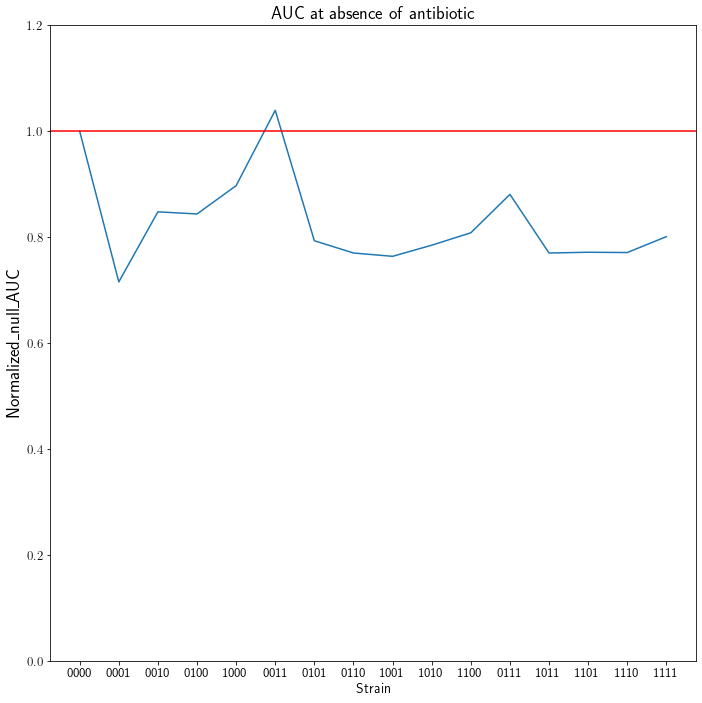

In [582]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(bin_str, Area_rep[0]/Area_rep[0][0])
plt.axhline(y = Area_rep[0][0]/Area_rep[0][0], color = 'r', linestyle = '-')
plt.title("AUC at absence of antibiotic", fontsize =18)
plt.xlabel("Strain")
plt.ylim(0,1.2)
plt.ylabel("Normalized_null_AUC ",fontsize =18)
fig.tight_layout()
plt.yticks(fontsize =13)
plt.xticks(fontsize =13)
fig.savefig("Normalized_null_AUC ")


### Ambiguity in AUC 

In [583]:
#Find the range of ambiguity
Area_range = []
for i in range(len(Area_rep)):
    Area_range_conc = []
    for j in range(len(Area_rep[0])):
        m = Area_rep[i][j]- Error_rep[i][j]
        if m < 0:
            m = 0
        Area_range_conc.append((m, Area_rep[i][j]+ Error_rep[i][j] ))
    Area_range.append(Area_range_conc)
        

### Fitting Hill Functions

In [584]:
### finding the Hill functions
from scipy.optimize import curve_fit

para = []
cov = []
fit_error = []
for i in range(len(np.array(Area).T)):
    def func(x, r0, m, n): # Hill functions
        y = r0/(1+(x/m)**n)
        return y
    x = curve_fit(func,np.array(conc) + 0.001,np.array(Area_rep).T[i],p0 = [Area_rep[0][i]/Area_rep[0][0], conc[IC_50[i]], 3 ], sigma = np.array(Error_rep).T[i],
                  full_output = True, maxfev=1000000)
    #[np.array(Area_rep).T[i][0], conc[MIC_50[i]], 2]
    #sigma = np.array(Error_rep).T[i],absolute_sigma=  True, 
    para.append(x[0])
    cov.append(np.sqrt(np.diag(x[1]))/np.sqrt(11))
    
    #cov.append(x[1])
    fit_error.append(x[2]['fvec'])


### Continous fitted Landscape

C:\Users\USER\AppData\Local\Temp/ipykernel_19076/2238345767.py:40: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()


(array([-15., -10.,  -5.,   0.,   5.,  10.,  15.]),
 [Text(-15.0, 0, '$\\mathdefault{−15}$'),
  Text(-10.0, 0, '$\\mathdefault{−10}$'),
  Text(-5.0, 0, '$\\mathdefault{−5}$'),
  Text(0.0, 0, '$\\mathdefault{0}$'),
  Text(5.0, 0, '$\\mathdefault{5}$'),
  Text(10.0, 0, '$\\mathdefault{10}$'),
  Text(15.0, 0, '$\\mathdefault{15}$')])

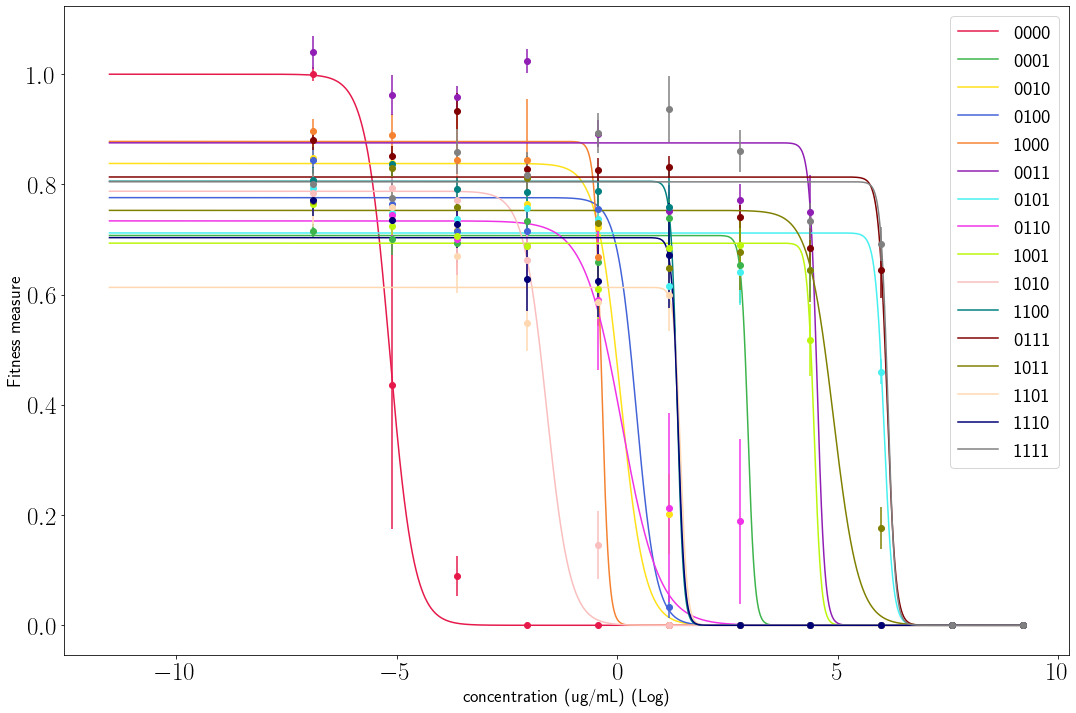

In [585]:
fig, ax = plt.subplots(figsize=(15, 10))
color = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
         '#008080',  '#800000','#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']
chi_test = []
r_null = []
MIC_fitted = []
IC_error = []
Hill_coeff = []
Hill_coeff_error = []
r_fitted = []
r_error = []
Area_cont = []
x_cont_1 = np.linspace(0.00001, 1, 10000)
x_cont_2 = np.linspace(1,10000, 1000000)
x_cont = np.concatenate((x_cont_1, x_cont_2))

for i in range(len(np.array(Area).T)):
    def func(x): # Hill functions
        y = para[i][0]/(1+(x/para[i][1])**para[i][2])
        return y
    r_null.append(para[i][0])
    r_error.append(cov[i][0])
    MIC_fitted.append(para[i][1])
    IC_error.append(cov[i][1])

    Hill_coeff.append(para[i][2])
    Hill_coeff_error.append(cov[i][2])
    x = np.array(conc)
    y = func(x)
    y_cont = (func(x_cont))
    r_fitted.append(list(y))
    Area_cont.append(y_cont )
    plt.plot(np.log(x_cont), y_cont/para[0][0], color = color[i], label = bin_str[i])
    plt.errorbar(np.log(np.array(conc)+ 0.001),np.array(Area_rep).T[i]/np.array(Area_rep).T[0][0], 
                     yerr = np.array(Error).T[i]/np.array(Area).T[0][0], fmt ='o', color = color[i])    
    plt.legend(fontsize = 20)

plt.xlabel("concentration (ug/mL) (Log)", fontsize =18)
plt.ylabel("Fitness measure ",fontsize =18)
fig.tight_layout()
plt.yticks(fontsize =25)
plt.xticks(fontsize =25)


In [586]:
#detecting the dead
for i in range(len(r_fitted)):
    for j in range(len(r_fitted[j])):
        if r_fitted[i][j] < 0.3848050753824383:
            r_fitted[i][j] = 0.0
for i in range(len(Area_cont)):
    for j in range(len(Area_cont[i])):
        if Area_cont[i][j] < 0.3848050753824383:
            Area_cont[i][j] = 0.0

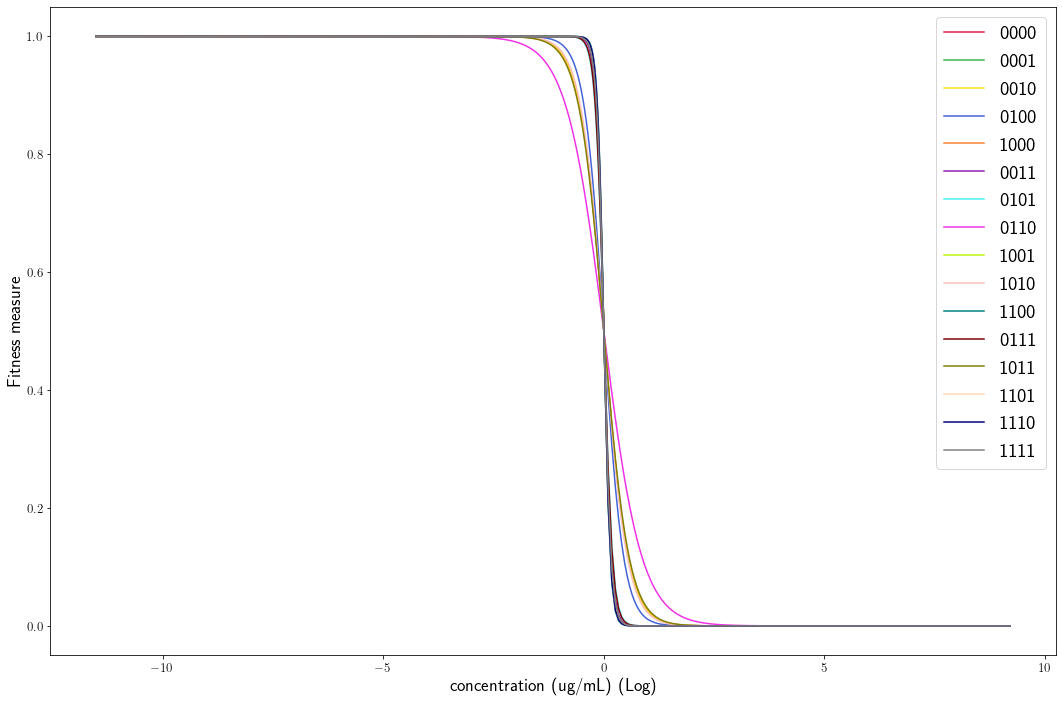

In [587]:
fig, ax = plt.subplots(figsize=(15, 10))
color = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
         '#008080',  '#800000','#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

for i in range(len(np.array(Area).T)):
    def func(x): # Hill functions
        y = para[0][0]/(1+(x)**para[i][2])
        return y
    x_cont_1 = np.linspace(0.00001, 1, 10000)
    x_cont_2 = np.linspace(1,10000, 100000)
    x_cont = np.concatenate((x_cont_1, x_cont_2))
    y_cont = (func(x_cont))
    plt.plot(np.log(np.array(x_cont)), y_cont/para[0][0], color = color[i], label = bin_str[i])
    plt.legend(fontsize = 20)

    
plt.xlabel("concentration (ug/mL) (Log)", fontsize =18)
plt.ylabel("Fitness measure ", fontsize =18)
fig.tight_layout()
plt.yticks(fontsize =13)
plt.xticks(fontsize =13)
fig.savefig('Hill_functions_collapsed.png')

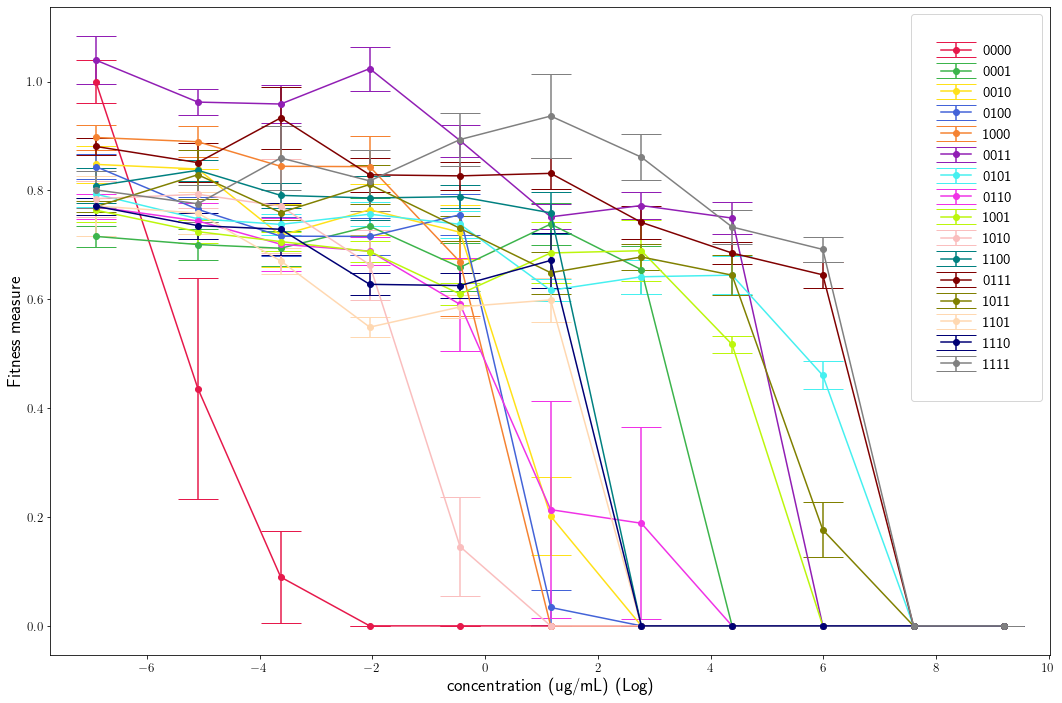

In [588]:
fig, ax = plt.subplots(figsize=(15, 10))
color = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
         '#008080',  '#800000','#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

for j in range(len(bin_str)):
        plt.errorbar(np.log(np.array(conc)+ 0.001),np.array(Area_rep).T[j]/np.array(Area_rep).T[0][0], 
                     yerr = np.array(Error_rep).T[j]/np.array(Area_rep).T[0][0], fmt ='o''-', capsize=20, color = color[j], label = bin_str[j])
        plt.xlabel("concentration (ug/mL) (Log)", fontsize =18)
        plt.ylabel("Fitness measure ", fontsize =18)
        plt.legend(fontsize = 15,  borderpad=2)
fig.tight_layout()
plt.yticks(fontsize =13)
plt.xticks(fontsize =13)
fig.savefig('Hill_functions_error_bar.png')


### Epistasis in expeimental data

### show the same pattern of positivity as in the fitted results

In [589]:
Area = Area_rep = np.array(r_fitted).T
for i in range(len(Area_rep)):
    for j in range(len(Area_rep[i])):
        if Area_rep[i][j] == 0.0:
            Area_rep[i][j] = 0.35
Area_rep = Area_rep/Area_rep[0][0]

In [590]:
#epistasis in null fitness in experimental data
r_null_exp = np.array(Area_rep)[0]/np.array(Area_rep).T[0][0]
r_error_exp = np.array(Error_rep)[0]/np.array(Area_rep).T[0][0]
No_ep_null_r = []
No_ep_error_r = []
for j in range(len(bin_str)):
    Non_ep = 1
    Non_er = 0
    if float(bin_str[j][3]) == 1:
        Non_ep = Non_ep*r_null_exp [1] 
        Non_er = Non_er + r_error_exp[1]/r_null_exp[1]
    if float(bin_str[j][2]) == 1:
        Non_ep = Non_ep*r_null_exp [2]
        Non_er = Non_er + r_error_exp[2]/r_null_exp[2]

    if float(bin_str[j][1]) == 1:
        Non_ep = Non_ep*r_null_exp[3]
        Non_er = Non_er + r_error_exp[3]/r_null_exp[3]
    if float(bin_str[j][0]) == 1:
        Non_ep = Non_ep*r_null_exp [4]
        Non_er = Non_er + r_error[4]/r_null_exp[4]

    No_ep_null_r.append(Non_ep)
    No_ep_error_r.append(Non_er)
ep_null_f =  r_null_exp/ No_ep_null_r


In [591]:
#epistasis in fitness values
No_ep_null_f = []
No_ep_error_r = []
ep_f_exp = []
for j in range(len(bin_str)):
    No_ep_null_f_temp = []
    No_ep_error_r_temp = []
    ep_temp = []
    for i in range(len(conc)):
        Non_ep = 1
        Non_er = 0
        mut = 0
        if float(bin_str[j][3]) == 1:
            Non_ep = Non_ep*np.array(Area_rep).T[1][i]
            Non_er = Non_er + np.array(Error_rep).T[1][i]/np.array(Area_rep).T[1][i]
            mut += 1
        if float(bin_str[j][2]) == 1:
            Non_ep = Non_ep*np.array(Area_rep).T[2][i]
            Non_er = Non_er + np.array(Error_rep).T[2][i]/np.array(Area_rep).T[2][i]
            mut += 1
        if float(bin_str[j][1]) == 1:
            Non_ep = Non_ep*np.array(Area_rep).T[3][i]
            Non_er = Non_er + np.array(Error_rep).T[3][i]/np.array(Area_rep).T[3][i]
            mut += 1
        if float(bin_str[j][0]) == 1:
            Non_ep = Non_ep*np.array(Area_rep).T[4][i]
            Non_er = Non_er + np.array(Error_rep).T[4][i]/np.array(Area_rep).T[4][i]
            mut += 1
        
        No_ep_null_f_temp.append(Non_ep)
        No_ep_error_r_temp.append(Non_er)
        ep_temp.append(np.array(Area_rep).T[j][i])
    No_ep_null_f.append(No_ep_null_f_temp)
    No_ep_error_r.append(No_ep_error_r_temp)
    ep_f_exp.append(ep_temp)


Error_tot = np.array(No_ep_error_r).T + np.array(Error_rep)/np.array(Area_rep)

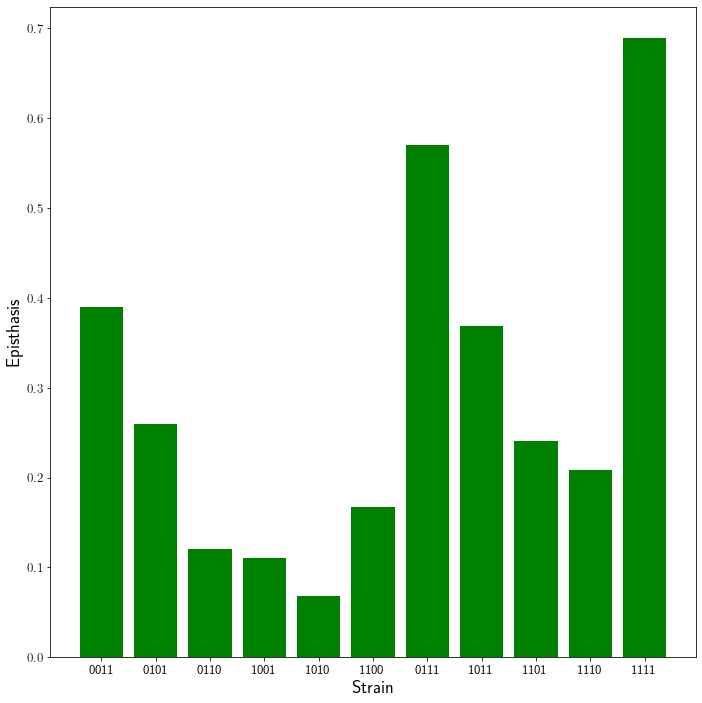

In [592]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.bar(bin_str[5:16], np.log(ep_null_f[5:16]), color ="green")
#plt.axhline(y = Area_rep[0][0]/Area_rep[0][0], color = 'r', linestyle = '-')
plt.xlabel("Strain", fontsize =18)
plt.ylabel("Episthasis ", fontsize =18)
fig.tight_layout()
plt.yticks(fontsize =13)
plt.xticks(fontsize =13)
fig.savefig('Episthasis in Null fitness')


### Final data labels

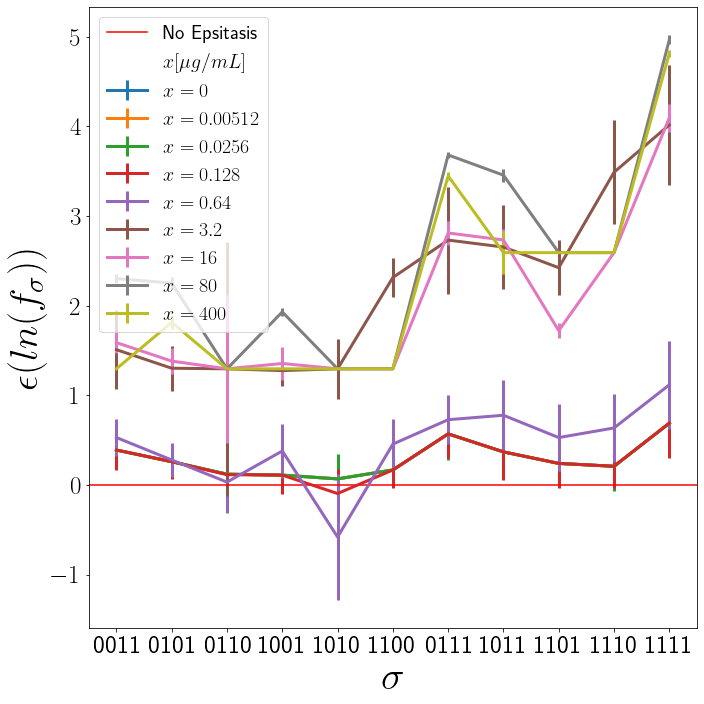

In [593]:

fig, ax = plt.subplots(figsize=(10, 10))
for i in range(len(Area_rep[:9])):
    plt.errorbar(bin_str[5:], np.log(Area_rep[i]/np.array(No_ep_null_f).T[i])[5:], yerr = Error_tot[i][5:], label = "$x= {}$".format(conc[i]), linewidth= 3)
    
plt.axhline(y = 0.0, color = 'r', linestyle = '-',label = "No Epsitasis")
plt.axhline(y = -1.5, color = 'white', linestyle = '-',label = r"$x [\mu g/mL]$")

plt.xlabel(r"$\sigma$", fontsize =40)
plt.ylabel(r"$\epsilon(ln(f_{\sigma}))$", fontsize =40)
plt.legend(fontsize = 20)    


#plt.plot(bin_str, 0.60*(-np.log(No_ep_null_f)))
#plt.axhline(y = np.log(Area_rep[0][0]/Area_rep[0][0]), color = 'r', linestyle = '-',label = "Wild Type Null Fitness")

plt.yticks(fontsize =25)
plt.xticks(fontsize =25)
fig.tight_layout()

fig.savefig('fitness_epistasis')


### Fitting mus and nus

In [594]:
### averaging mus:

mu_s = []

mu_s.append(np.log(-np.log(Area_rep[0][5]/Area_rep[0][0]))/ np.log(- np.log(Area_rep[0][1]/Area_rep[0][0])- np.log(Area_rep[0][2]/Area_rep[0][0])))
mu_s.append(np.log(-np.log(Area_rep[0][6]/Area_rep[0][0]))/ np.log(-np.log(Area_rep[0][1]/Area_rep[0][0]) -np.log(Area_rep[0][3]/Area_rep[0][0])))
mu_s.append(np.log(-np.log(Area_rep[0][7]/Area_rep[0][0]))/ np.log(-np.log(Area_rep[0][2]/Area_rep[0][0]) -np.log(Area_rep[0][3]/Area_rep[0][0])))
mu_s.append(np.log(-np.log(Area_rep[0][8]/Area_rep[0][0]))/ np.log(-np.log(Area_rep[0][1]/Area_rep[0][0]) -np.log(Area_rep[0][4]/Area_rep[0][0])))
mu_s.append(np.log(-np.log(Area_rep[0][9]/Area_rep[0][0]))/ np.log(-np.log(Area_rep[0][2]/Area_rep[0][0]) -np.log(Area_rep[0][4]/Area_rep[0][0])))
mu_s.append(np.log(-np.log(Area_rep[0][10]/Area_rep[0][0]))/ np.log(-np.log(Area_rep[0][3]/Area_rep[0][0]) -np.log(Area_rep[0][4]/Area_rep[0][0])))
mu_s.append(np.log(-np.log(Area_rep[0][11]/Area_rep[0][0]))/ np.log(-np.log(Area_rep[0][3]/Area_rep[0][0]) -np.log(Area_rep[0][2]/Area_rep[0][0])-np.log(Area_rep[0][1]/Area_rep[0][0])))
mu_s.append(np.log(-np.log(Area_rep[0][12]/Area_rep[0][0]))/ np.log(-np.log(Area_rep[0][1]/Area_rep[0][0]) -np.log(Area_rep[0][4]/Area_rep[0][0]) -np.log(Area_rep[0][2]/Area_rep[0][0])))
mu_s.append(np.log(-np.log(Area_rep[0][13]/Area_rep[0][0]))/ np.log(-np.log(Area_rep[0][3]/Area_rep[0][0]) -np.log(Area_rep[0][4]/Area_rep[0][0])-np.log(Area_rep[0][1]/Area_rep[0][0])))
mu_s.append(np.log(-np.log(Area_rep[0][14]/Area_rep[0][0]))/ np.log(-np.log(Area_rep[0][3]/Area_rep[0][0]) -np.log(Area_rep[0][4]/Area_rep[0][0])-np.log(Area_rep[0][2]/Area_rep[0][0])))
mu_s.append(np.log(-np.log(Area_rep[0][14]/Area_rep[0][0]))/ np.log(-np.log(Area_rep[0][3]/Area_rep[0][0]) -np.log(Area_rep[0][4]/Area_rep[0][0])-np.log(Area_rep[0][2]/Area_rep[0][0]) -np.log(Area_rep[0][1]/Area_rep[0][0])))

# average through the number of mutations
print("mean mu:", np.mean((0.617, 0.480, 0.0939)))
print("std mu:", np.std((0.617, 0.480, 0.0939)))

mean mu: 0.3969666666666667
std mu: 0.22147882266458094


In [595]:
### averaging nus:

nu_s = []

nu_s.append(np.log(np.log(IC_50_fit[5]))/ np.log(np.log(IC_50_fit[1]) + np.log(IC_50_fit[2])))
nu_s.append(np.log(np.log(IC_50_fit[6]))/ np.log(np.log(IC_50_fit[1]) + np.log(IC_50_fit[3])))
nu_s.append(np.log(np.log(IC_50_fit[7]))/ np.log(np.log(IC_50_fit[2]) + np.log(IC_50_fit[3])))
nu_s.append(np.log(np.log(IC_50_fit[8]))/ np.log(np.log(IC_50_fit[1]) + np.log(IC_50_fit[4])))
nu_s.append(np.log(np.log(IC_50_fit[9]))/ np.log(np.log(IC_50_fit[2]) + np.log(IC_50_fit[4])))
nu_s.append(np.log(np.log(IC_50_fit[10]))/ np.log(np.log(IC_50_fit[3]) + np.log(IC_50_fit[4])))
nu_s.append(np.log(np.log(IC_50_fit[11]))/ np.log(np.log(IC_50_fit[3]) + np.log(IC_50_fit[2])+ np.log(IC_50_fit[1])))
nu_s.append(np.log(np.log(IC_50_fit[12]))/ np.log(np.log(IC_50_fit[1]) + np.log(IC_50_fit[4]) + np.log(IC_50_fit[2])))
nu_s.append(np.log(np.log(IC_50_fit[13]))/ np.log(np.log(IC_50_fit[3]) + np.log(IC_50_fit[4])+ np.log(IC_50_fit[1])))
nu_s.append(np.log(np.log(IC_50_fit[14]))/ np.log(np.log(IC_50_fit[3]) + np.log(IC_50_fit[4])+ np.log(IC_50_fit[2])))
nu_s.append(np.log(np.log(IC_50_fit[14]))/ np.log(np.log(IC_50_fit[3]) + np.log(IC_50_fit[4])+ np.log(IC_50_fit[2]) + np.log(IC_50_fit[1])))

print("mean nus:", np.mean((0.789, 0.737, 0.593)))
print("std nus:", np.std((0.789, 0.737, 0.593)))

mean nus: 0.7063333333333333
std nus: 0.08290288830245236


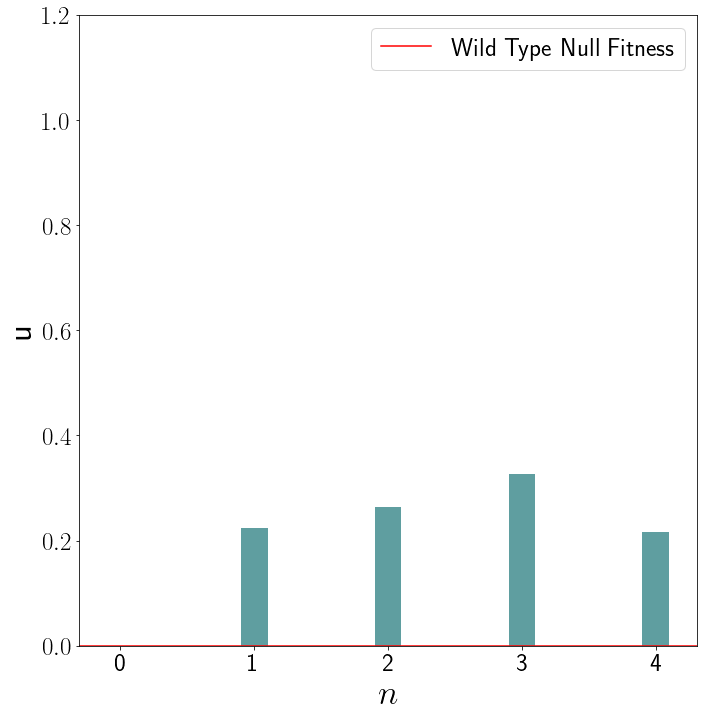

In [596]:
Area_rep_averaged = [Area_rep[0][0]/Area_rep[0][0], np.mean(Area_rep[0][1:5])/Area_rep[0][0],np.mean(Area_rep[0][5:11])/Area_rep[0][0], np.mean(Area_rep[0][11:15])/Area_rep[0][0], np.mean(Area_rep[0][-1])/Area_rep[0][0] ]
X_label = ("0", "1", "2", "3", "4")

fig, ax = plt.subplots(figsize=(10, 10))
plt.bar(X_label, -np.log(Area_rep_averaged), width=0.2, color = "cadetblue")
plt.axhline(y = -np.log(Area_rep[0][0]/Area_rep[0][0]), color = 'r', linestyle = '-',label = "Wild Type Null Fitness")

plt.ylim(0,1.2)
plt.legend(fontsize = 25)
plt.ylabel(r"u", fontsize =35)
plt.xlabel(r"$n$", fontsize =35)
fig.tight_layout()
plt.yticks(fontsize =25)
plt.xticks(fontsize =25)
plt.gcf().subplots_adjust(left=0.12)

fig.savefig('fitted_AUC at absence of antibiotic_new')


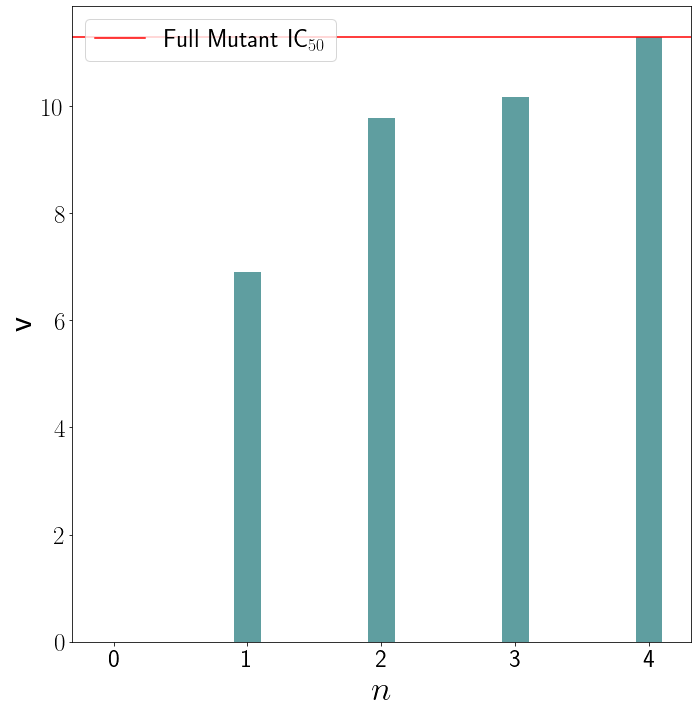

In [597]:
IC_50_avg = [IC_50_fit[0], np.mean(IC_50_fit[1:5]), np.mean(IC_50_fit[5:11]), np.mean(IC_50_fit[11:15]), IC_50_fit[15] ]

fig, ax = plt.subplots(figsize=(10, 10))
X_label = ("0", "1", "2", "3", "4")
plt.bar(X_label,np.log(IC_50_avg), width=0.2, color = "cadetblue")

#plt.plot(bin_str, IC_50)
plt.axhline(y = np.log(IC_50_avg[-1]), color = 'r', linestyle = '-', label = r"Full Mutant IC$_{50}$")
plt.ylabel(r"v",fontsize =35)
plt.legend(fontsize = 25)
plt.xlabel(r"$n$", fontsize =35)

fig.tight_layout()
plt.yticks(fontsize =25)
plt.xticks(fontsize =25)
plt.gcf().subplots_adjust(left=0.12)

fig.savefig('fitted_IC_50_new')


slop -0.013799457470556017
R_square 0.17355354535468892


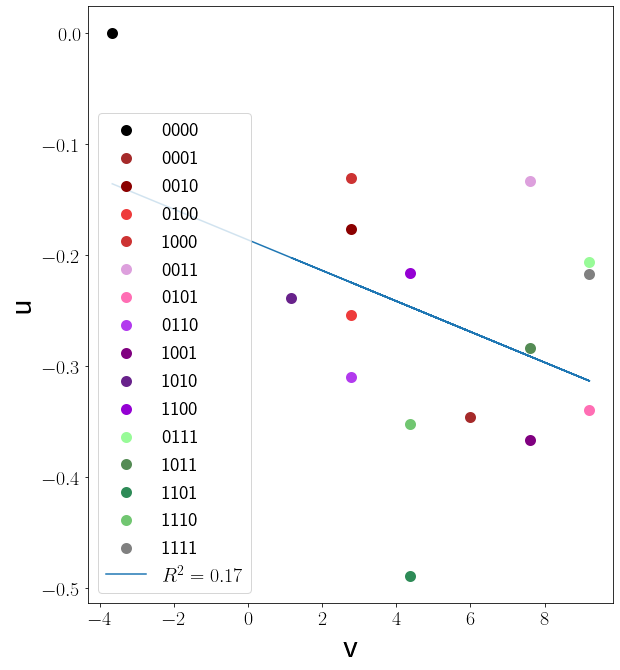

In [598]:
fig, ax = plt.subplots(figsize=(10, 10))
color = ['#000000', '#A52A2A', '#8B0000', '#EE3B3B', '#CD3333', '#DDA0DD', '#FF6EB4', '#B23AEE', '#800080', '#68228B', 
         '#9400D3',  '#98FB98','#548B54', '#2E8B57', '#71C671', '#808080', '#ffffff', '#000000']


r0 = []
MIC_copy = MIC_50.copy() 
x = []
bin_s = []
for i in range(len(bin_str)):
    r0.append(np.log(Area_rep[0][i]/Area_rep[0][0]))
    plt.scatter(np.log(5**(MIC_50[i])*0.00512), np.log(Area_rep[0][i]/Area_rep[0][0]), color= color[i], marker = "o", linewidths = 5,  label = bin_str[i])
    x.append(5**(MIC_50[i])*0.00512)
    bin_s.append(bin_str[i])
    plt.legend(fontsize = 15)


def func(x,c, a): #linear function
    y = c*x + a
    return y

para, cov = curve_fit(func, np.log(x), r0, method='lm', maxfev=1000000)
plt.plot(np.log(x), para[0]*np.array(np.log(x)) + para[1], label = r"$ R^{2} = 0.17$")
plt.legend(fontsize = 20)
print("slop",para[0])
plt.ylabel(r"u", fontsize =35)
plt.xlabel(r"v", fontsize =35)
SSerr = sum((r0 - (para[0]*np.array(np.log(x)) +para[1]))**2)
SStot = sum((r0 - sum(r0)/(len(r0)))**2)


fig.tight_layout()
plt.yticks(fontsize =20)
plt.xticks(fontsize =20)
fig.savefig('Trade_off_raw_fitted')
plt.gcf().subplots_adjust(left=0.25)
plt.gcf().subplots_adjust(bottom=0.15)

Rsq= 1 - (SSerr/SStot)
print("R_square", Rsq)



###try tp eleminate some points to detect tradeoff

### Episthasis

In [599]:
No_ep_null_f = []
No_ep_error_r = []
mutations = []
for j in range(len(bin_str)):
    Non_ep = 1
    Non_er = 0
    mut = 0
    if float(bin_str[j][3]) == 1:
        Non_ep = Non_ep*r_null [1] 
        Non_er = Non_er + r_error[1]/r_null[1]
        mut +=1
    if float(bin_str[j][2]) == 1:
        Non_ep = Non_ep*r_null [2]
        Non_er = Non_er + r_error[2]/r_null[2]
        mut +=1

    if float(bin_str[j][1]) == 1:
        Non_ep = Non_ep*r_null [3]
        Non_er = Non_er + r_error[3]/r_null[3]
        mut +=1

    if float(bin_str[j][0]) == 1:
        Non_ep = Non_ep*r_null [4]
        Non_er = Non_er + r_error[4]/r_null[4]
        mut +=1
    mutations.append(mut)
    No_ep_null_f.append(Non_ep)
    No_ep_error_r.append(Non_er)

In [600]:
No_ep_IC50 = []
No_ep_error_IC = []


for j in range(len(bin_str)):
    Non_ep = 1
    Non_er = 0
    c = 0
    if float(bin_str[j][3]) == 1:
        Non_ep = Non_ep*IC_50_fit[1]
        Non_er = Non_er + IC_error[1]/IC_50_fit[1]
        c += 1
        
    if float(bin_str[j][2]) == 1:
        Non_ep = Non_ep*IC_50_fit[2]
        Non_er = Non_er + IC_error[2]/IC_50_fit[2]
        c += 1

    if float(bin_str[j][1]) == 1:
        Non_ep = Non_ep*IC_50_fit[3]
        Non_er = Non_er + IC_error[3]/IC_50_fit[3]
        c += 1

    if float(bin_str[j][0]) == 1:
        Non_ep = Non_ep*IC_50_fit[4]
        Non_er = Non_er + IC_error[4]/IC_50_fit[4]
        c += 1
    No_ep_IC50.append(Non_ep)
    No_ep_error_IC.append(Non_er)

In [601]:
sigma_r = np.array(No_ep_error_r)
sigma_n = np.array(Hill_coeff_error) 
sigma_x = 0.001
sigma_m = np.array(No_ep_error_IC)
m = np.array(No_ep_IC50)
n = np.array(Hill_coeff)
r = np.array(No_ep_null_f) 
x = np.array(conc) +0.001
error_non_ep = []
non_ep_fitness = []
for i in range(len(bin_str)):
    non_ep_fitness_gen = []
    error_non_ep_gen = []
    for j in range(len(conc)):
        non_ep_fitness_gen.append(No_ep_null_f[i]/(1+ ((conc[j] + 0.0001)/(No_ep_IC50[i]*MIC_fitted[0]))**Hill_coeff[i]))#No_ep_IC50[i]*MIC_fitted[0] becasue we divided by MIC_fitted in the beginning 
        error_non_ep_gen.append(np.sqrt(sigma_r[i]**2/(((x[j]/m[i])**n[i] + 1)**2) + (r[i]**2*sigma_n[i]**2*(x[j]/m[i])**(2*n[i])*np.log((x[j]/m[i])**2))/(((x[j]/m[i])**n[i] + 1)**4) + (n[i]**2*r[i]**2*sigma_x**2*(x[j]/m[i])**(2*n[i]))/((x[j]**2*((x[j]/m[i])**n[i] + 1)**4)) + (n[i]**2*r[i]**2*sigma_m[i]**2*(x[j]/m[i])**(2*n[i]))/((m[i]**2*((x[j]/m[i])**n[i] + 1)**4))))
    non_ep_fitness.append(non_ep_fitness_gen)
    error_non_ep.append(error_non_ep_gen)

C:\Users\USER\AppData\Local\Temp/ipykernel_19076/523360083.py:16: RuntimeWarning: invalid value encountered in sqrt
  error_non_ep_gen.append(np.sqrt(sigma_r[i]**2/(((x[j]/m[i])**n[i] + 1)**2) + (r[i]**2*sigma_n[i]**2*(x[j]/m[i])**(2*n[i])*np.log((x[j]/m[i])**2))/(((x[j]/m[i])**n[i] + 1)**4) + (n[i]**2*r[i]**2*sigma_x**2*(x[j]/m[i])**(2*n[i]))/((x[j]**2*((x[j]/m[i])**n[i] + 1)**4)) + (n[i]**2*r[i]**2*sigma_m[i]**2*(x[j]/m[i])**(2*n[i]))/((m[i]**2*((x[j]/m[i])**n[i] + 1)**4))))


In [602]:
ep = []
for i in range(len(non_ep_fitness)):
    ep_gen = []
    for j in range(len(non_ep_fitness[i])):
        ep_gen.append(Area.T[i][j]/non_ep_fitness[i][j])
    ep.append(ep_gen)

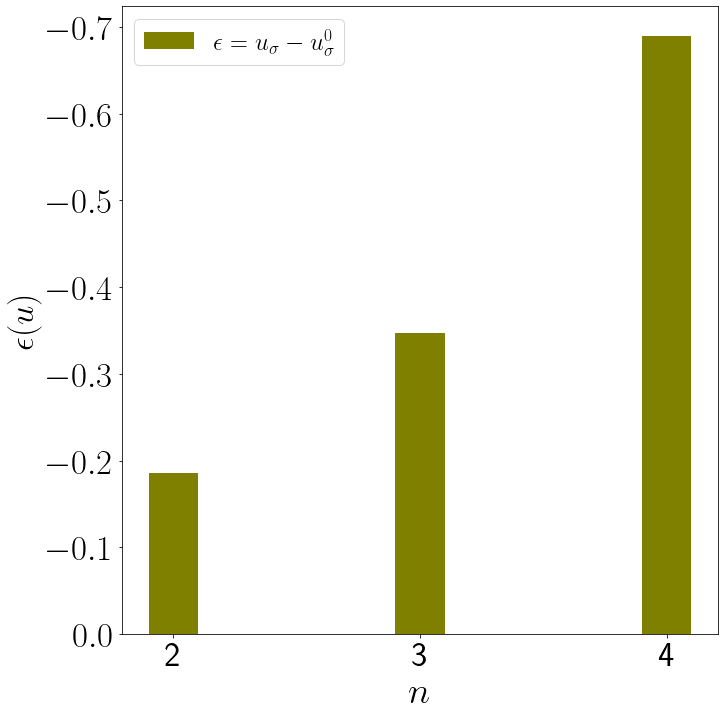

In [603]:
ep_null_log = [np.mean(- np.log(ep_null_f[5:11])),np.mean(-np.log(ep_null_f[11:15])), -np.mean(np.log(ep_null_f[15]))] 
X_label = ( "2", "3", "4")

fig, ax = plt.subplots(figsize=(10, 10))

plt.bar(X_label, ep_null_log, width=0.2, color ="olive", label = r"$\epsilon = u_{\sigma} - u_{\sigma}^{0}$")
#plt.axhline(y = Area_rep[0][0]/Area_rep[0][0], color = 'r', linestyle = '-')
plt.ylabel(r"$\epsilon (u)$ ", fontsize =35)
plt.xlabel(r"$n$", fontsize =38)
plt.legend(fontsize = "25")
fig.tight_layout()
plt.yticks(fontsize =35)
plt.xticks(fontsize =35)
plt.gca().invert_yaxis()

plt.gcf().subplots_adjust(left=0.15)

fig.savefig('Episthasis in Null fitness_new')


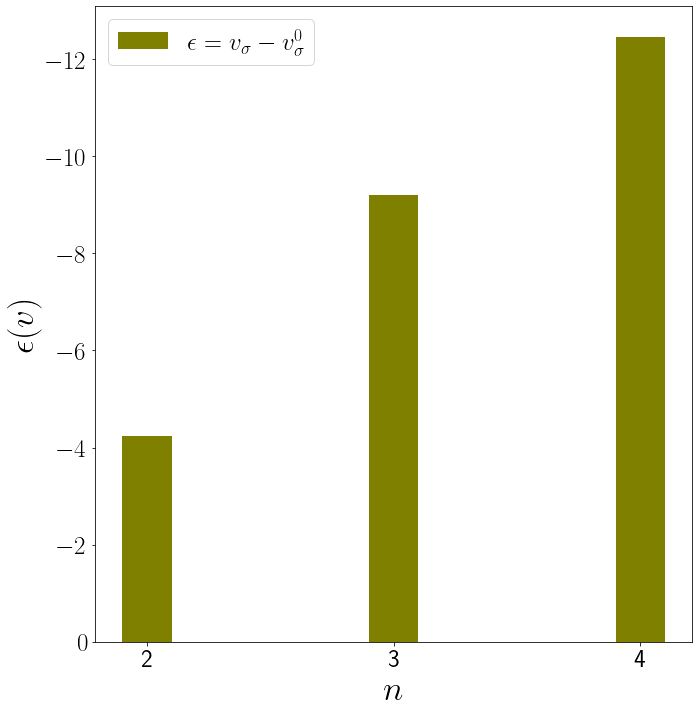

In [604]:
ep_IC_log = [np.mean(np.log(ep_IC_50[5:11])),np.mean(np.log(ep_IC_50[11:15])), np.mean(np.log(ep_IC_50[15]))] 

fig, ax = plt.subplots(figsize=(10, 10))
plt.bar(X_label, np.array(ep_IC_log), width=0.2, color ="olive", label = r"$\epsilon = v_{\sigma} - v_{\sigma}^{0}$")


plt.gca().invert_yaxis()
plt.ylabel(r"$\epsilon (v)$ ", fontsize =35)
plt.xlabel(r"$n$", fontsize =35)
plt.legend(fontsize = "25")

fig.tight_layout()
plt.yticks(fontsize =25)
plt.xticks(fontsize =25)
plt.gcf().subplots_adjust(left=0.15)

fig.savefig('Episthasis in IC_50_new')


### Linear tradeoff fitted

### Tradeoff behavior

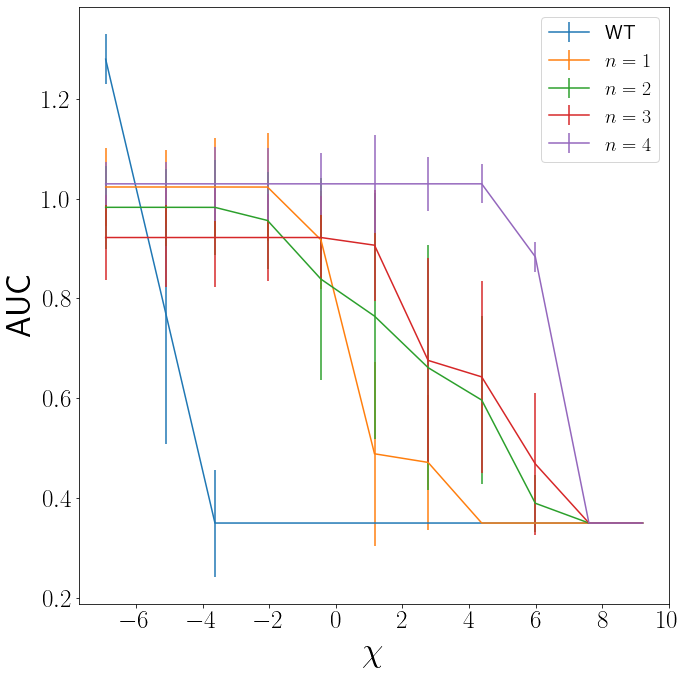

In [605]:
fig, ax = plt.subplots(figsize=(10, 10))

#Fitness per mutation 
Area_mut_1 = []
Area_mut_2 = []
Area_mut_3 = []
Area_mut_4 = []
Area_mut_5 = []
std_mut_1 = []
std_mut_2 = []
std_mut_3 = []
std_mut_4 = []
std_mut_5 = []


for i in range(len(Area)):
    Area_mut_1.append(Area[i][0])
    Area_mut_2.append(np.mean(Area[i][1:5]))
    Area_mut_3.append(np.mean(Area[i][5:11]))
    Area_mut_4.append(np.mean(Area[i][11:15]))
    Area_mut_5.append(Area[i][15])
    std_mut_1.append(np.mean(Error_rep[i][0]))
    std_mut_2.append(np.std(Area[i][1:5])/np.sqrt(len(Area[i][1:5][0:3] )) + np.mean(Error_rep[i][1:5]))
    std_mut_3.append(np.std(Area[i][5:11])/np.sqrt(len(Area[i][5:11][0:3]))+ np.mean(Error_rep[i][5:11]))
    std_mut_4.append(np.std(Area[i][11:15])/np.sqrt(len(Area[i][11:15][0:3]))+ np.mean(Error_rep[i][11:15]))
    std_mut_5.append(np.mean(Error_rep[i][15]))

plt.errorbar(np.log(np.array(conc)+ 0.001),np.array(Area_mut_1), yerr = np.array(std_mut_1), label = r"WT")

plt.errorbar(np.log(np.array(conc)+ 0.001),np.array(Area_mut_2), yerr = np.array(std_mut_2), label = r"$n = 1$")

plt.errorbar(np.log(np.array(conc)+ 0.001),np.array(Area_mut_3), yerr = np.array(std_mut_3),label = r"$n = 2$")

plt.errorbar(np.log(np.array(conc)+ 0.001), np.array(Area_mut_4), yerr = np.array(std_mut_4),label = r"$n = 3$")

plt.errorbar(np.log(np.array(conc)+ 0.001),np.array(Area_mut_5), yerr = np.array(std_mut_5),label = r"$n = 4$")


plt.xlabel(r"$\chi$", fontsize =35)
plt.ylabel("AUC", fontsize =35)
fig.tight_layout()
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.legend(fontsize = 20)
plt.gcf().subplots_adjust(left=0.15)
plt.gcf().subplots_adjust(bottom=0.15)

fig.savefig('Tradoff_mutation')

### Landscape Generation (Data)

In [606]:
#ordering sequences according to fitness = area
z = np.arange(0,16)

ordered_seq = []
for i in range(len(Area)):
    c = sort_together([Area[i], bin_str])
    ordered_seq.append(c[1])


In [607]:
#ordered_para, the number is the strength of the ordered seq from 0000 to 1111, where the first digit is the strenght of 0000.
#power give order ofthe genotype at a particuler concentration from the strongest to the weekest
ordered_para = []
power = []
for i in range(len(ordered_seq)):
    ordered_para_sub =[]
    power_sub = []
    for j in range(len(ordered_seq[i])):
        ordered_para_sub.append(ordered_seq[i].index(bin_str[j]))
        power_sub.append(list(bin_str).index(ordered_seq[i][j]))
    ordered_para.append(ordered_para_sub )
    power_sub.reverse()
    power.append(power_sub)


0.2635294117647059

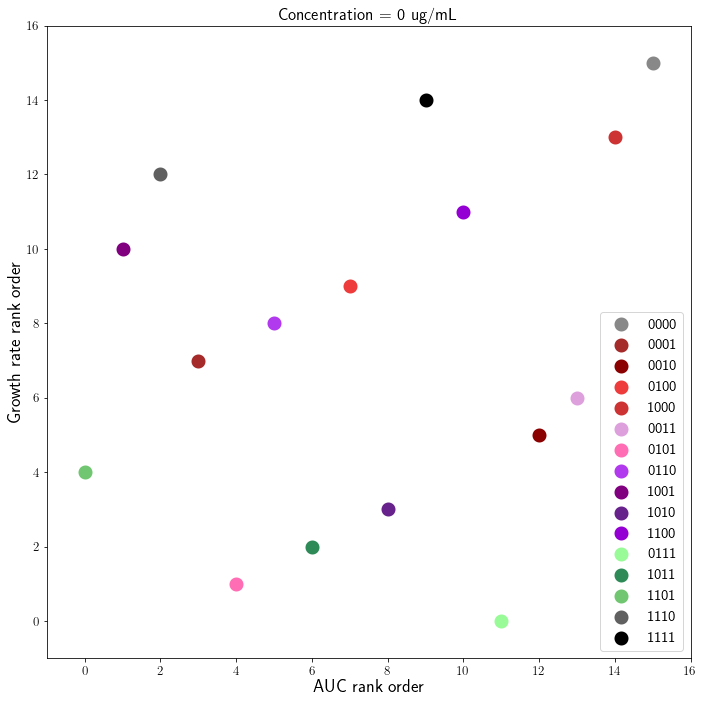

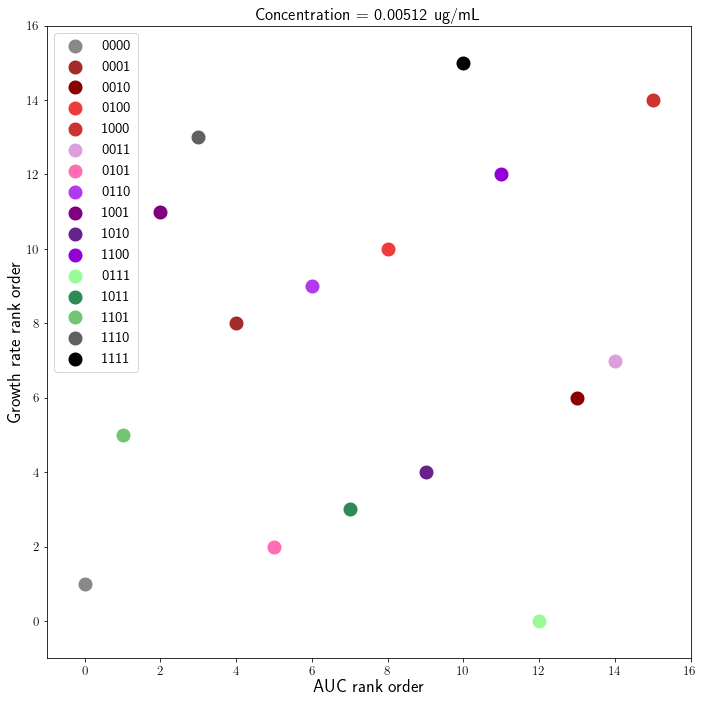

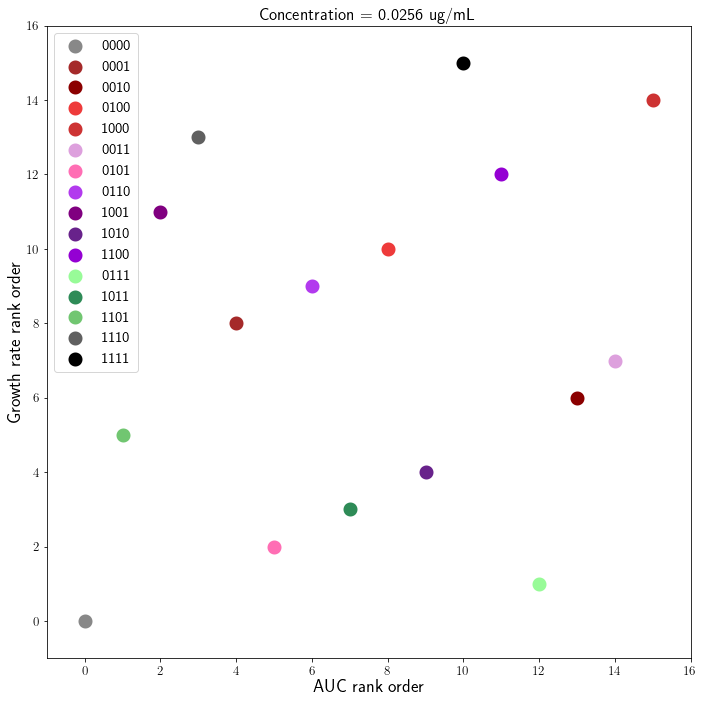

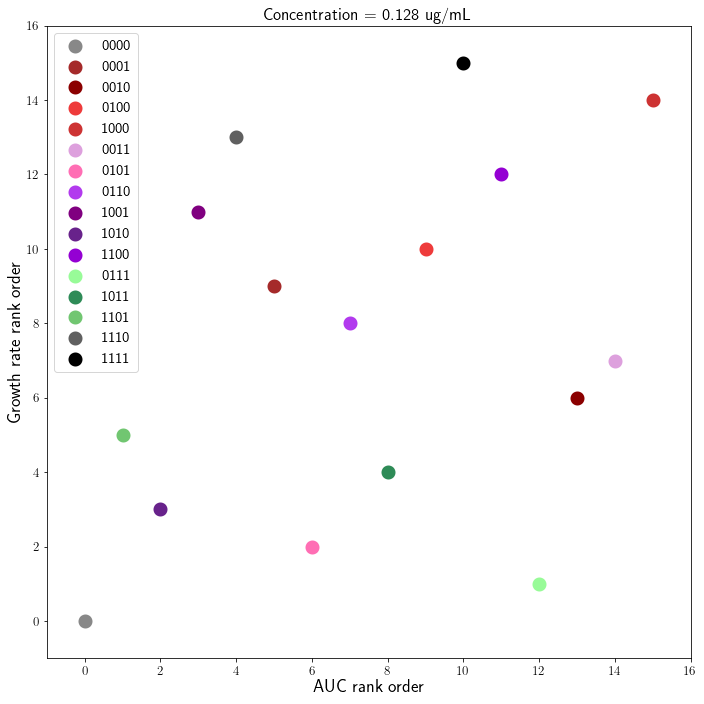

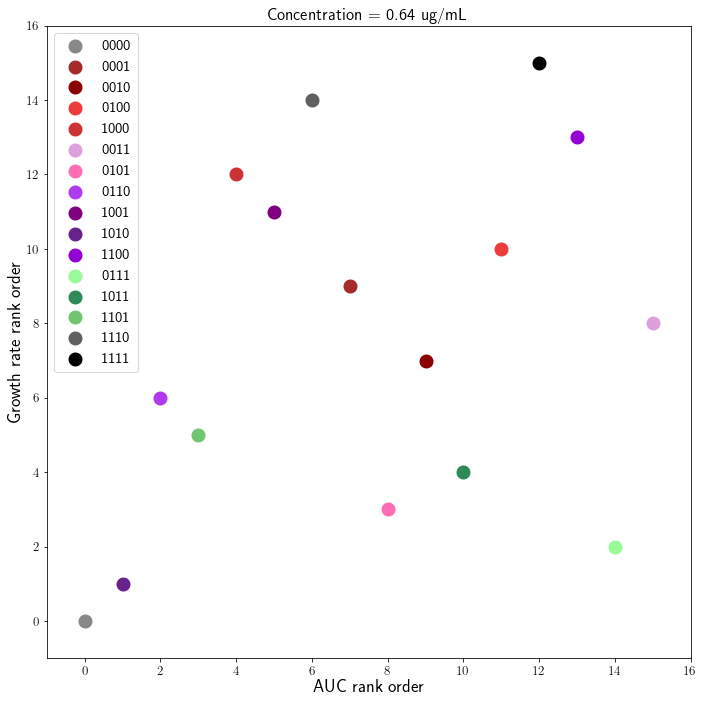

In [608]:
AUC_order = [[15, 3, 12, 7, 14, 13, 4, 5, 1, 8, 10, 11, 6, 0, 2, 9],[0, 4, 13, 8, 15, 14, 5, 6, 2, 9, 11, 12, 7, 1, 3, 10],[0, 4, 13, 8, 15, 14, 5, 6, 2, 9, 11, 12, 7, 1, 3, 10],[0, 5, 13, 9, 15, 14, 6, 7, 3, 2, 11, 12, 8, 1, 4, 10],[0, 7, 9, 11, 4, 15, 8, 2, 5, 1, 13, 14, 10, 3, 6, 12]]
r_order = [[15, 7, 5, 9, 13, 6, 1, 8, 10, 3, 11, 0, 2, 4, 12, 14],
 [1, 8, 6, 10, 14, 7, 2, 9, 11, 4, 12, 0, 3, 5, 13, 15],
 [0, 8, 6, 10, 14, 7, 2, 9, 11, 4, 12, 1, 3, 5, 13, 15],
 [0, 9, 6, 10, 14, 7, 2, 8, 11, 3, 12, 1, 4, 5, 13, 15],
 [0, 9, 7, 10, 12, 8, 3, 6, 11, 1, 13, 2, 4, 5, 14, 15]]

color = ['#888888', '#A52A2A', '#8B0000', '#EE3B3B', '#CD3333', '#DDA0DD', '#FF6EB4', '#B23AEE', '#800080', '#68228B', 
         '#9400D3',  '#98FB98', '#2E8B57', '#71C671', '#606060', '#000000']

for j in range(0,5):
    fig, ax = plt.subplots(figsize=(10, 10))

    for i in range(len(AUC_order[0])):
        plt.scatter(AUC_order[j][i], r_order[j][i],color= color[i], label = bin_str[i], marker = "o", linewidths = 8,)
    plt.xlim(-1,16)
    plt.ylim(-1,16)

    plt.legend(fontsize = 15)
    plt.xlabel("AUC rank order", fontsize= 18)
    plt.ylabel("Growth rate rank order", fontsize = 18)
    plt.yticks(fontsize =13)
    plt.xticks(fontsize =13)
    plt.title("Concentration = {} ug/mL".format(conc[j]))
    fig.tight_layout()

    fig.savefig('Rank order{}'.format(j))
a = []
b = []

for i in range(len(AUC_order)):
    for j in range(len(AUC_order[i])):
            for k in range(len(AUC_order[i])):
                    a.append(AUC_order[i][k]-AUC_order[i][j])
                    b.append(r_order[i][k]-r_order[i][j])
a = np.array(a)
b = np.array(b)
rank_coeff  = sum(a*b)/(sum(a**2))

rank_coeff

In [609]:
from itertools import product

def LFM(L,c, z):
    '''
    L: number of loci
    A: The concentration index.
    z: Genotype order of the data with 0000 =0  and 1111 = 15.
    '''
    y= ordered_para[c]
    ### Generating all possible sequences
    
    
    fit = {}
    for i in range(len(bin_str)):
        fit[bin_str[i]] = Area[c][i]
        
    #a dictionary attaching ordered sequences to normally_ordered numbers
    seq = {}
    for i in range(len(bin_str)):
        seq[bin_str[i]] = i
    
    

    #create all possible edge based on single loci difference
    edges = []
    for i in range(len(bin_str)):
        for j in range(len(bin_str)):
            diff = 0
            for k in range(L):
                diff += abs(int(bin_str[i][k]) - int(bin_str[j][k]))
            if diff == 1:
                edges.append([seq[bin_str[i]], seq[bin_str[j]]])

    #a dictionary attaching a fitness to a number
    parameter = {}
    y_new = [] #ordered parameter
    for i in range(len(z)):
        parameter['{}'.format(z[i])] = y[i]
        y_new.append(y[i])

    #remove edges from higher to lower fitness
    edges_copy = edges.copy()
    for i in range(len(edges)):
        if parameter['{}'.format(edges[i][0])] >= parameter['{}'.format(edges[i][1])]:
            edges_copy.remove([edges[i][0],edges[i][1]])

                
#Find out local fitness maxima by counting the number of edges coming into a node

    LFM = []
    Fitness = []
    fack_LFM= []
    fack_j = []
    fack_n = []
    for j in range(2**L):
        k = 0
        n = 0
        for i in range(len(edges_copy)):
            if edges_copy[i][1] == j:
                k += 1
            if edges_copy[i][0] == j:
                n += 1
        if k == 4 and n == 0:
            LFM.append(bin_str[j])
            Fitness.append(fit[bin_str[j]])
        if k ==4 and n != 0:
            fack_LFM.append(bin_str[j])
            fack_j.append(j)
            fack_n.append(n)
    fack_fack = []
    for j in fack_j:
        for i in range(len(edges_copy)):
            if edges_copy[i][0] == j and edges_copy[i][1] not in fack_j:
                fack_fack.append(j)
    for j in fack_j:
        if j not in fack_fack:
            LFM.append(bin_str[j])
            Fitness.append(fit[bin_str[j]])
    LFM_copy = LFM.copy()
    Fitness_copy = Fitness.copy()
    for j in LFM:
        for i in range(len(edges_copy)):
            if edges_copy[i][0] == bin_str.index(j) and bin_str[edges_copy[i][1]] not in LFM:
                if j in LFM_copy:
                    LFM_copy.remove(j)
                    Fitness_copy.remove(fit[j])
    LFM = LFM_copy 
    if len(LFM) != 0:
        Fitness = Fitness_copy
        g = sort_together([Fitness, LFM], reverse=True)
        LFM = g[1]
    return LFM

In [610]:
def Landscape(L,c, z):
    '''
    L: number of loci
    y: list of parameter values ordered according to genotype order z. Example: null fitness
       in a list ordered acoording to genotype order in z.
    z: Genotype order of the data with 0000 =0  and 1111 = 15.
    '''
    y= ordered_para[c] #ordered the index of sequences according to fitness
   
    #a dictionary attaching ordered sequences to ordered numbers
    seq = {}
    for i in range(len(bin_str)):
        seq[bin_str[i]] = i
    edge_color = []
    #create all possible edge based on single loci difference
    edges = []
    for i in range(len(bin_str)):
        for j in range(len(bin_str)):
            diff = 0
            for k in range(L):
                diff += abs(int(bin_str[i][k]) - int(bin_str[j][k]))
            if diff == 1:
                edges.append([seq[bin_str[i]], seq[bin_str[j]]])
                
                    
                edge_color.append("#c7b000")

    #a dictionary attaching a fitness to a number
    parameter = {}
    y_new = [] #ordered parameter
    for i in range(len(z)):
        parameter['{}'.format(z[i])] = y[i]
        y_new.append(y[i])

    #remove edges from higher to lower fitness
    edges_copy = edges.copy()
    for i in range(len(edges)):
        if parameter['{}'.format(edges[i][0])] > parameter['{}'.format(edges[i][1])]:
            edges_copy.remove([edges[i][0],edges[i][1]])
     


        g = Graph(n=2**L, edges= edges_copy, directed =True)

    import math
    x_lim = 100
    y_lim = 100
    x_lim_final = 320
    y_lim_final = 320
    y_sum = []
    y_length= y_lim/(L+1)

    y_position = 20
    for i in range(L+1):
        y_position += y_length
        y_sum.append(y_position)

    number_of_nodes_in_y = []
    for i in range(L+1):
        number_of_nodes_in_y.append(math.factorial(L)/(math.factorial(L-i)*math.factorial(i)))

    coor = []

    x_position = 0
    for i in range(len(y_sum)):
        x_position = 20
        x_len = x_lim/(number_of_nodes_in_y [i]+1)
        n = int(number_of_nodes_in_y [i])
        for j in range(n):
            x_position += x_len
            coor.append([x_position, y_sum[i]])
    layout = coor
    
    color = ["#006400", "#579002", "#699603", "#7c9b05", "#90a007","#a4a509", "#a99a0b", "#ae8e0e", "#b28210", "#b77513", 
 "#bb6816", "#bf5b19", "#c24e1c","#c6411f", "#ca3322", "#EE0000"]
    color_copy = color.copy()
    
    number_dead =0
    for i in range(len(bin_str)):
        if Area[c][i]< 0.02:
            number_dead += 1
        
    
    m = sort_together([power[c], color])
    col = list(m[1]) 
    col_copy = list(m[1]) 
    for i in range(len(bin_str)):
        if Area[c][i] < 0.02 :
            col[i] = "white"
        
        
    ver_size = []
    ver_col = []
    
    for i in range(len(bin_str)):
        if bin_str[i] in LFM(4,c,z):
            ver_size.append(25)
            ver_col.append("red")
        else:
            ver_size.append(17)
            ver_col.append("black")
    
    
    return ig.plot(g,  "Fitness_Landscape{}.png".format(c), layout = layout,edge_curved= 0, 
                   vertex_color = col,  edge_color ="grey52",vertex_label= bin_str ,
                   vertex_label_angle = 4.8, bbox=(0, -10, x_lim_final, y_lim_final), 
                   vertex_size = ver_size, vertex_label_dist= 1.7, vertex_label_size = 20, vertex_label_color = ver_col )


In [611]:
def edges(L, c, z):
    '''
    L: number of loci
    y: list of parameter values ordered according to genotype order z. Example: null fitness
       in a list ordered acoording to genotype order in z.
    z: Genotype order of the data with 0000 =0  and 1111 = 15.
    '''
    y = ordered_para[c]


    

    #a dictionary attaching ordered sequences to ordered numbers
    seq = {}
    for i in range(len(bin_str)):
        seq[bin_str[i]] = i

    #create all possible edge based on single loci difference
    edges = []
    for i in range(len(bin_str)):
        for j in range(len(bin_str)):
            diff = 0
            for k in range(L):
                diff += abs(int(bin_str[i][k]) - int(bin_str[j][k]))
            if diff == 1:
                edges.append((seq[bin_str[i]], seq[bin_str[j]]))

    #a dictionary attaching a fitness to a number
    parameter = {}
    y_new = [] #ordered parameter
    for i in range(len(z)):
        parameter['{}'.format(z[i])] = y[i]
        y_new.append(y[i])
        


    #remove edges from higher to lower fitness
    edges_copy = edges.copy()
    for i in range(len(edges)):
        if parameter['{}'.format(edges[i][0])] >= parameter['{}'.format(edges[i][1])]:
            edges_copy.remove((edges[i][0],edges[i][1]))

    return edges_copy

In [612]:
for i in range(len(conc)):
    Landscape(4, i, z)


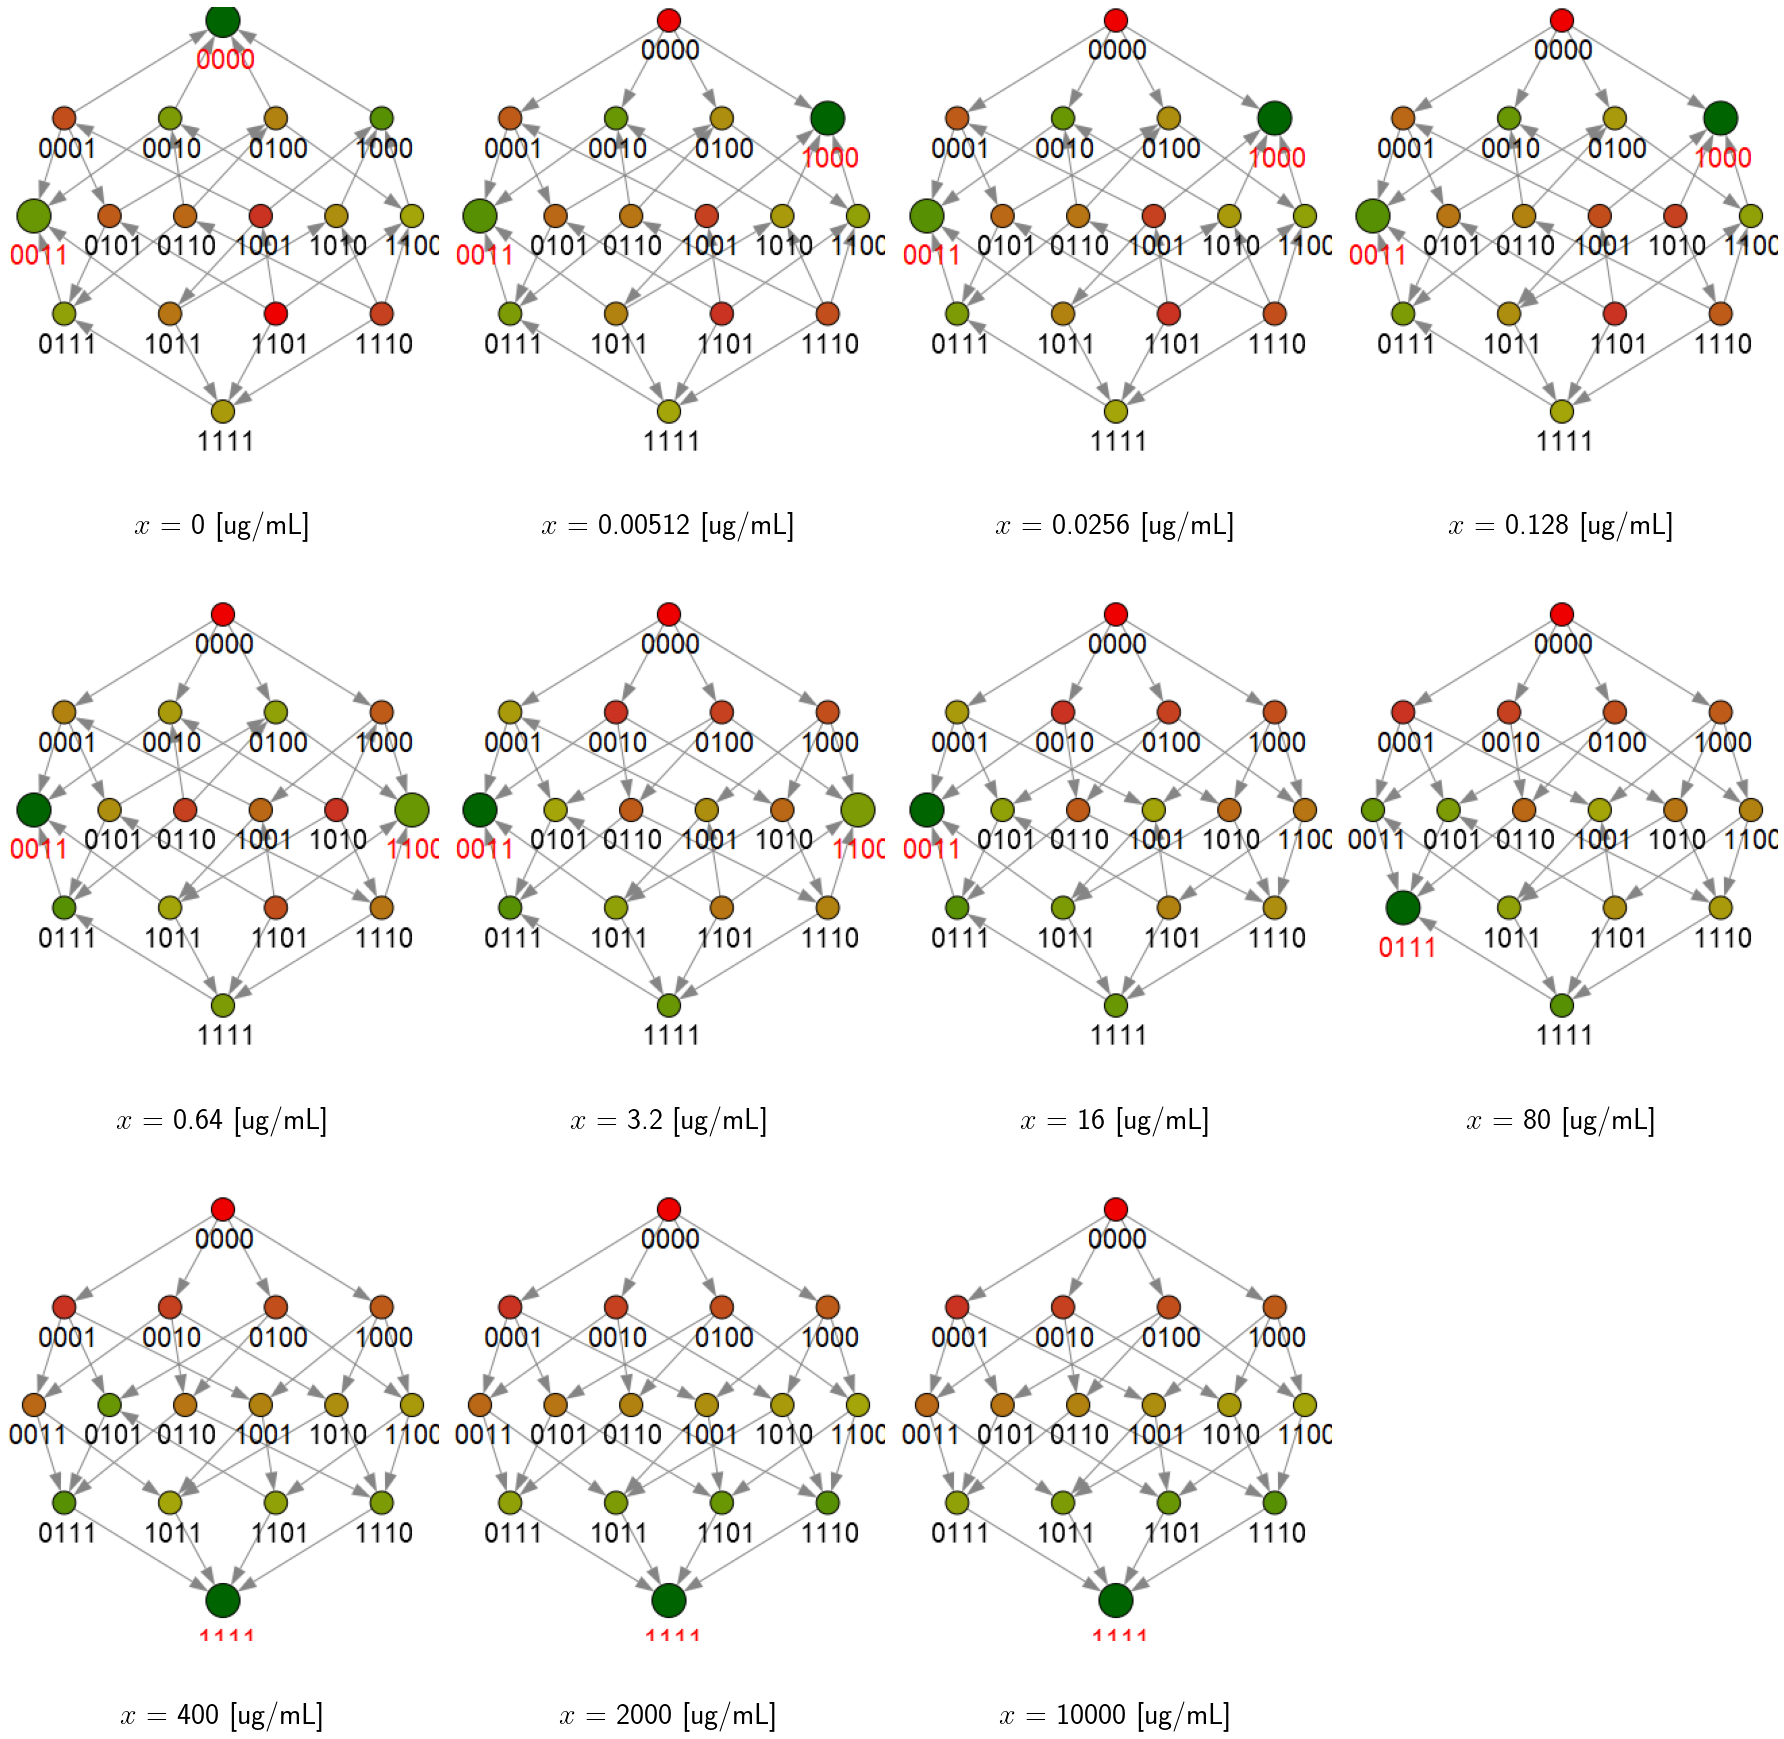

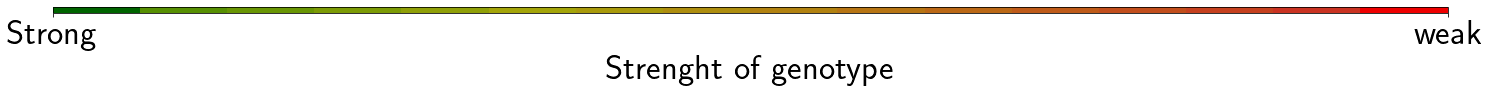

In [613]:
import matplotlib.image as mpimg
import matplotlib as mpl
from mycolorpy import colorlist as mcp
for i in range(len(conc)):
    Landscape(4, i, z)

fig, ax = plt.subplots(nrows=3,ncols=4,figsize=(25, 25))
ax[-1, -1].axis('off')
fig.patch.set_facecolor('xkcd:white')
for i in range(len(conc)):
    plt.subplot(3,4,i +1)
    plt.axis('off')
    img=mpimg.imread('Fitness_Landscape{}.png'.format(i))
    imgplot=plt.imshow(img)
    plt.title(r"$x$ = {} [ug/mL] ".format(conc[i]), y=-0.2, fontsize =30)
    fig.tight_layout()
    plt.yticks(fontsize =13)
    plt.xticks(fontsize =13)
    fig.savefig('Fitness_Landscapes_color.png')
    


fig1, ax1 = plt.subplots(figsize=(25, 1))
fig1.subplots_adjust(bottom=0.8)
green = Color("green")
colors = list(green.range_to(Color("red"),16))
cmap =  mpl.colors.ListedColormap(colors = ["#006400", "#579002", "#699603", "#7c9b05", "#90a007","#a4a509", "#a99a0b", "#ae8e0e", "#b28210", "#b77513", 
 "#bb6816", "#bf5b19", "#c24e1c","#c6411f", "#ca3322", "#EE0000"])
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap, 
                                orientation='horizontal')
cb1.set_label('Strenght of genotype',weight='bold', fontsize = 35)
cb1.set_ticks([0, 1])
cb1.set_ticklabels(["Strong", "weak"],weight='bold', fontsize = 45)
fig.tight_layout()
plt.yticks(fontsize =35)
plt.xticks(fontsize =35)
fig1.savefig('Fitness_Landscapes_color_bar.png')


In [614]:
all_LFM = []
all_edges = []
for i in range(len(ordered_para)):
        edge_Landscape = edges(4,i, z)
        Local_LFM = LFM(4,i,z)
        all_edges.append(edge_Landscape)
        all_LFM.append(Local_LFM)

num_max = []
for i in all_LFM:
    num_max.append(len(i))

### IC_50 landscape

In [615]:
from itertools import product

def LFM_IC(L, z):
    '''
    L: number of loci
    A: The concentration index.
    z: Genotype order of the data with 0000 =0  and 1111 = 15.
    '''
    y= MIC_fitted
    ### Generating all possible sequences
        
    #a dictionary attaching ordered sequences to normally_ordered numbers
    seq = {}
    for i in range(len(bin_str)):
        seq[bin_str[i]] = i
    
    fit = {}
    for i in range(len(bin_str)):
        fit[bin_str[i]] = IC_50[i]

    #create all possible edge based on single loci difference
    edges = []
    for i in range(len(bin_str)):
        for j in range(len(bin_str)):
            diff = 0
            for k in range(L):
                diff += abs(int(bin_str[i][k]) - int(bin_str[j][k]))
            if diff == 1:
                edges.append([seq[bin_str[i]], seq[bin_str[j]]])

    #a dictionary attaching a fitness to a number
    parameter = {}
    y_new = [] #ordered parameter
    for i in range(len(z)):
        parameter['{}'.format(z[i])] = y[i]
        y_new.append(y[i])

    #remove edges from higher to lower fitness
    edges_copy = edges.copy()
    for i in range(len(edges)):
        if parameter['{}'.format(edges[i][0])] > parameter['{}'.format(edges[i][1])]:
            edges_copy.remove([edges[i][0],edges[i][1]])
            
   
                
#Find out local fitness maxima by counting the number of edges coming into a node

    LFM = []
    Fitness = []
    fack_LFM= []
    fack_j = []
    fack_n = []
    for j in range(2**L):
        k = 0
        n = 0
        for i in range(len(edges_copy)):
            if edges_copy[i][1] == j:
                k += 1
            if edges_copy[i][0] == j:
                n += 1
        if k == 4 and n == 0:
            LFM.append(bin_str[j])
            Fitness.append(fit[bin_str[j]])
        if k ==4 and n != 0:
            fack_LFM.append(bin_str[j])
            fack_j.append(j)
            fack_n.append(n)
    fack_fack = []
    for j in fack_j:
        for i in range(len(edges_copy)):
            if edges_copy[i][0] == j and edges_copy[i][1] not in fack_j:
                fack_fack.append(j)
    for j in fack_j:
        if j not in fack_fack:
            LFM.append(bin_str[j])
            Fitness.append(fit[bin_str[j]])
    LFM_copy = LFM.copy()
    Fitness_copy = Fitness.copy()
    for j in LFM:
        for i in range(len(edges_copy)):
            if edges_copy[i][0] == bin_str.index(j) and bin_str[edges_copy[i][1]] not in LFM:
                if j in LFM_copy:
                    LFM_copy.remove(j)
                    Fitness_copy.remove(fit[j])
    LFM = LFM_copy 
    if len(LFM) != 0:
        Fitness = Fitness_copy
        g = sort_together([Fitness, LFM], reverse=True)
        LFM = g[1]
            
    return LFM

In [616]:
def Landscape_IC(L, z):
    '''
    L: number of loci
    y: list of parameter values ordered according to genotype order z. Example: null fitness
       in a list ordered acoording to genotype order in z.
    z: Genotype order of the data with 0000 =0  and 1111 = 15.
    '''
    y= MIC_fitted #ordered the index of sequences according to fitness
    ### Generating all possible sequences

    #a dictionary attaching ordered sequences to ordered numbers
    seq = {}
    for i in range(len(bin_str)):
        seq[bin_str[i]] = i
    edge_color = []
    #create all possible edge based on single loci difference
    edges = []
    for i in range(len(bin_str)):
        for j in range(len(bin_str)):
            diff = 0
            for k in range(L):
                diff += abs(int(bin_str[i][k]) - int(bin_str[j][k]))
            if diff == 1:
                edges.append([seq[bin_str[i]], seq[bin_str[j]]])

    #a dictionary attaching a fitness to a number
    parameter = {}
    y_new = [] #ordered parameter
    for i in range(len(z)):
        parameter['{}'.format(z[i])] = y[i]
        y_new.append(y[i])

    #remove edges from higher to lower fitness
    edges_copy = edges.copy()
    for i in range(len(edges)):
        if parameter['{}'.format(edges[i][0])] > parameter['{}'.format(edges[i][1])]:
            edges_copy.remove([edges[i][0],edges[i][1]])
        elif parameter['{}'.format(edges[i][0])] < parameter['{}'.format(edges[i][1])]:
            edge_color.append("#000000")
        else :
            edge_color.append("#808080")
   

   

    g = Graph(n=2**L, edges= edges_copy, directed =True)

    import math
    x_lim = 100
    y_lim = 100
    x_lim_final = 320
    y_lim_final = 320
    y_sum = []
    y_length= y_lim/(L+1)

    y_position = 10
    for i in range(L+1):
        y_position += y_length
        y_sum.append(y_position)

    number_of_nodes_in_y = []
    for i in range(L+1):
        number_of_nodes_in_y.append(math.factorial(L)/(math.factorial(L-i)*math.factorial(i)))

    coor = []

    x_position = 0
    for i in range(len(y_sum)):
        x_position = 10
        x_len = x_lim/(number_of_nodes_in_y [i]+1)
        n = int(number_of_nodes_in_y [i])
        for j in range(n):
            x_position += x_len
            coor.append([x_position, y_sum[i]])
    layout = coor
    
    
    color = ["#EE0000","#c6411f", "#c24e1c", "#bb6816", "#b28210", "#a99a0b","#90a007", "#699603","#006400"]
    
    col = []
    for i in range(len(IC_50)):
        col.append(color[IC_50[i]-1])
    
    
    LFM = LFM_IC(4,z)
    
        
        
    ver_size = []
    
    for i in range(len(bin_str)):
        if bin_str[i] in LFM:
            ver_size.append(25)
        else:
            ver_size.append(17)
    
    
    return ig.plot(g,  "IC50_Landscape.png", layout = layout,edge_curved= 0, 
                   vertex_color = col, vertex_label= bin_str , edge_color = edge_color,
                   vertex_label_angle = 4.8, bbox=(0, -10, x_lim_final, y_lim_final), 
                   vertex_size = ver_size, vertex_label_dist= 1.7, vertex_label_size = 15)


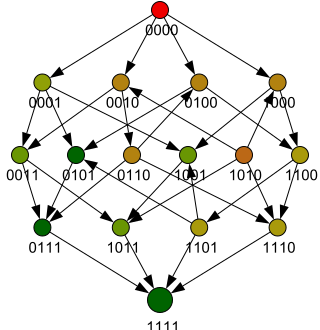

In [617]:
Landscape_IC(4,z)



### Accessibilty

In [618]:
def accessibility(Geno_type, conc):
    sample = edges(4,conc,z)
    
     #a dictionary attaching ordered sequences to ordered numbers
    seq = {}
    for i in range(len(bin_str)):
        seq[bin_str[i]] = i
    string = {}
    for i in range(len(bin_str)):
        string[i] = bin_str[i]
        
    x = seq[Geno_type]    
    stock = []
    variable =[x]
    for i in range(len(sample)):
        stock.append(sample[i][0])

    check =  any(item in variable for item in  stock)
    variable_copy_copy = variable.copy()
    while check is True:
        variable_copy = variable.copy()
        for j in range(len(variable_copy)):
            if variable_copy[j] in stock:
                a = variable_copy[j]
                for k in range(len(sample)):
                    if sample[k][0] == a and sample[k][1] not in variable_copy_copy:
                        variable.append(sample[k][1])
                        variable_copy_copy.append(sample[k][1])
                variable.remove(a)
        check =  any(item in variable for item in  stock)
        if check is False:
            break
    variable_seq = []
    for i in variable:
        variable_seq.append(string[i])
        
    return variable_seq

In [619]:
def edges_IC_50(L,z):
    '''
    L: number of loci
    y: list of parameter values ordered according to genotype order z. Example: null fitness
       in a list ordered acoording to genotype order in z.
    z: Genotype order of the data with 0000 =0  and 1111 = 15.
    '''
    y = IC_50


    ### Generating all possible sequences

    #a dictionary attaching ordered sequences to ordered numbers
    seq = {}
    for i in range(len(bin_str)):
        seq[bin_str[i]] = i

    #create all possible edge based on single loci difference
    edges = []
    for i in range(len(bin_str)):
        for j in range(len(bin_str)):
            diff = 0
            for k in range(L):
                diff += abs(int(bin_str[i][k]) - int(bin_str[j][k]))
            if diff == 1:
                edges.append([seq[bin_str[i]], seq[bin_str[j]]])

    #a dictionary attaching a fitness to a number
    parameter = {}
    y_new = [] #ordered parameter
    for i in range(len(z)):
        parameter['{}'.format(z[i])] = y[i]
        y_new.append(y[i])
        


    #remove edges from higher to lower fitness
    edges_copy = edges.copy()
    for i in range(len(edges)):
        if parameter['{}'.format(edges[i][0])] > parameter['{}'.format(edges[i][1])]:
            edges_copy.remove([edges[i][0],edges[i][1]])
  
    final_edges = []
    for i in range(len(edges_copy)):
        final_edges.append((edges_copy[i][0], edges_copy[i][1]))

    return final_edges

In [620]:
def accessibility_IC_50(Geno_type):
    sample = edges_IC_50(4,z)
    
     #a dictionary attaching ordered sequences to ordered numbers
    seq = {}
    for i in range(len(bin_str)):
        seq[bin_str[i]] = i
    string = {}
    for i in range(len(bin_str)):
        string[i] = bin_str[i]
        
    x = seq[Geno_type]    
    stock = []
    variable =[x]
    for i in range(len(sample)):
        stock.append(sample[i][0])

    check =  any(item in variable for item in  stock)
    variable_copy_copy = variable.copy()
    while check is True:
        variable_copy = variable.copy()
        for j in range(len(variable_copy)):
            if variable_copy[j] in stock:
                a = variable_copy[j]
                for k in range(len(sample)):
                    if sample[k][0] == a and sample[k][1] not in variable_copy_copy:
                        variable.append(sample[k][1])
                        variable_copy_copy.append(sample[k][1])
                variable.remove(a)
        check =  any(item in variable for item in  stock)
        if check is False:
            break
    variable_seq = []
    for i in variable:
        variable_seq.append(string[i])
        
    return variable_seq

In [621]:
Access = {}
List_Access = []
for j in range(len(conc)):
    List_Access_sub = []
    for i in range(len(bin_str)):
        Access[bin_str[i], j] = accessibility(bin_str[i], j)
        for k in (accessibility(bin_str[i], j)):
            List_Access_sub.append(k)
    List_Access.append(List_Access_sub)


In [622]:
Count_Access = []
for j in range(len(List_Access)):
    count_access = {i:List_Access[j].count(i) for i in List_Access[j]}
    Count_Access.append(count_access)

### Number of times the direction switch

In [623]:
edges_0=[(0, 1), (0, 2), (0, 3), (0, 4), (1, 6), (1, 8), (1, 5), (2, 7), (2, 5), (2, 9), (3,6), (3,10), (3,7), (4,8), (4,9), (4,10),
(5,11), (5,12), (6,11), (6,13), (7,11), (7, 14), (8,12), (8,13), (9, 12), (9, 14), (10, 13), (10, 14), (11,15), (12, 15), (13, 15),(14, 15)]
edges_1 = [(1, 0), (2, 0), (3, 0), (4, 0), (6, 1), (8, 1), (5, 1), (7, 2), (5, 2), (9, 2), (6,3), (10,3), (7,3), (8,4), (9,4), (10,4),
(11,5), (12,5), (11,6), (13,6), (11,7), (14, 7), (12,8), (13,8), (12, 9), (14, 9), (13, 10), (14, 10), (15,11), (15, 12), (15, 13),(15, 14)]


In [624]:
all_exist_edges = []
for n in range(len(edges_0)):
    exist_edge = []
    for i in range(len(all_edges)):
        if len(exist_edge) == 0:
            if edges_0[n] in all_edges[i] and edges_1[n] not in all_edges[i]:
                exist_edge.append("→ ")
            elif edges_0[n] not in all_edges[i] and edges_1[n] in all_edges[i]:
                exist_edge.append("←")
            else:
                exist_edge.append("-")
        else:
            if edges_0[n] in all_edges[i] and edges_1[n] not in all_edges[i]:
                exist_edge.append("→ ")
            elif edges_0[n] not in all_edges[i] and edges_1[n] in all_edges[i]:
                exist_edge.append("←")
            else:
                exist_edge.append(exist_edge[i-1])
                
            
    all_exist_edges.append(exist_edge)

In [625]:
C = []
for i in range(len(all_exist_edges)):
    c = 0
    for j in range(len(all_exist_edges[i])):
        if j != 0:
            if all_exist_edges[i][j] != all_exist_edges[i][j-1]:
                if all_exist_edges[i][j -1] != "-":
                        c += 1
                else:
                        c += 0
    C.append(c)
    
    

In [626]:
order = {}
for i in range(len(bin_str)):
    order[i] = bin_str[i]


In [627]:
all_exist_edges_copy = all_exist_edges.copy()
for i in range(len(all_exist_edges)):
    all_exist_edges[i] = []
    all_exist_edges[i].append(all_exist_edges_copy[i][0])
    all_exist_edges[i].append(all_exist_edges_copy[i][-1])

    all_exist_edges[i].append(C[i])
conc_direction = ["0", "10000"]
conc_direction.append("# of intersections")
edges_0_ord = edges_0
edges_0_seq = []
for i in range(len(edges_0_ord)):
    edges_0_seq.append((order[edges_0_ord[i][0]], order[edges_0_ord[i][1]]))
    
    

In [628]:
def color_negative(v, color):
    return f"color: {color};" if v > 1 else None
df = pd.DataFrame(all_exist_edges, index=np.array(edges_0_seq), columns=conc_direction)
df.style.applymap(color_negative, color='red', subset = "# of intersections")  

,0,10000,# of intersections
"('0000', '0001')",←,→,1
"('0000', '0010')",←,→,1
"('0000', '0100')",←,→,1
"('0000', '1000')",←,→,1
"('0001', '0101')",→,→,0
"('0001', '1001')",←,→,1
"('0001', '0011')",→,→,0
"('0010', '0110')",←,→,1
"('0010', '0011')",→,→,0
"('0010', '1010')",←,→,1


### Ascending transitions

In [629]:
#rewrite LFM as sequences and rank

set_LFM = []
for i in range(len(all_LFM) -1):
    if all_LFM[i + 1] == all_LFM[i]:
        pass
    else:
        if all_LFM[i] not in set_LFM:
            set_LFM.append(all_LFM[i])
set_LFM.append(all_LFM[i+1])

stable_states = []
for i in range(len(set_LFM)):
    for j in range(len(set_LFM[i])):
        if set_LFM[i][j] not in stable_states:
            stable_states.append(set_LFM[i][j])
seq = {}
for i in range(len(bin_str)):
    seq[bin_str[i]] = i
    
#rank order
gen_stable = []

for i in (stable_states):
    gen_stable.append(seq[i])

gen_LFM = []
for i in range(len(all_LFM)):
    gen_LFM_sub = []
    for j in range(len(all_LFM[i])):
        gen_LFM_sub.append(seq[all_LFM[i][j]])
    gen_LFM.append(gen_LFM_sub )

In [630]:
greedy = []
total_edges = []
check_list = []
for i in range(len(all_LFM)):
    if i < len(all_edges) -1:
        if all_LFM[i] != all_LFM[i+1]:
            for j in range(len(all_LFM[i])):
                if gen_LFM[i][j] not in gen_LFM[i+1]:
                    check_list_edges = []
                    dummy_var  = gen_LFM[i][j]
                    for k in range(len(all_edges[i+1])):
                        if all_edges[i+1][k][0] == dummy_var:
                            check_list_edges.append(all_edges[i+1][k])
                    if len(check_list_edges) != 0 :
                        check_copy = []
                        while check_list_edges != check_copy:
                            check_copy = check_list_edges.copy()
                            for h in range(len(check_list_edges)):
                                dummy_var = check_list_edges[h][1]
                                for s in range(len(all_edges[i+1])):
                                    if all_edges[i+1][s][0] == dummy_var and all_edges[i+1][s] not in check_list_edges:
                                        check_list_edges.append(all_edges[i+1][s])
                    check_list.append(check_list_edges)
                    
                    LFM_i1 = LFM(4, i+1, z)
                    LFM_i_seq = []
                    for w in LFM_i1:
                        LFM_i_seq.append(seq[w])
        
                    order = []
                    LFM_gen_i1_greedy = []
                    LFM_gen_i1 = []
                    for g in range(len(check_list_edges)):
                        if check_list_edges[g][1] in LFM_i_seq:
                            LFM_gen_i1.append(check_list_edges[g][1])
                            order.append(ordered_para[i+1].index(check_list_edges[g][1]))
                    if len(order) != 0:
                        LFM_gen_i1_greedy.append(ordered_para[i+1][order[order.index(np.max(order))]])
                    
                        
                    for m in range(len(check_list_edges)):
                        if check_list_edges[m][1] in LFM_gen_i1:
                            if check_list_edges[m][1]in LFM_gen_i1_greedy:
                                the_edge = (gen_LFM[i][j],check_list_edges[m][1])
                                if len(greedy) == 0:
                                    greedy.append(the_edge)
                                if the_edge != greedy[-1]:
                                    greedy.append(the_edge)
                            else:
                                the_edge = (gen_LFM[i][j],check_list_edges[m][1])
                                if len(total_edges) == 0:
                                    total_edges.append(the_edge)
                                if the_edge not in total_edges:
                                    total_edges.append(the_edge)

In [631]:
for i in (LFM(4,10,z)):
    x = i.format('')
    greedy.append((seq[x], seq[x]))

In [632]:
total_A = []

edges_A = []

greedy_edges_A = []

    
for i in range(len(greedy)):
    greedy_edges_A.append((gen_stable.index(greedy[i][0]),gen_stable.index(greedy[i][1]) ))
    edges_A.append((gen_stable.index(greedy[i][0]),gen_stable.index(greedy[i][1]) ))
for i in range(len(total_edges)):
    if total_edges[i] not in total_A:
        edges_A.append((gen_stable.index(total_edges[i][0]),gen_stable.index(total_edges[i][1]) ))
        total_A.append((gen_stable.index(total_edges[i][0]),gen_stable.index(total_edges[i][1]) )) #not greedy
        

### Decending edges

In [633]:
def edges(L, c, z):
    '''
    L: number of loci
    y: list of parameter values ordered according to genotype order z. Example: null fitness
       in a list ordered acoording to genotype order in z.
    z: Genotype order of the data with 0000 =0  and 1111 = 15.
    '''
    y = ordered_para[c]


    ### Generating all possible sequences
    

    #a dictionary attaching ordered sequences to ordered numbers
    seq = {}
    for i in range(len(bin_str)):
        seq[bin_str[i]] = i

    #create all possible edge based on single loci difference
    edges = []
    for i in range(len(bin_str)):
        for j in range(len(bin_str)):
            diff = 0
            for k in range(L):
                diff += abs(int(bin_str[i][k]) - int(bin_str[j][k]))
            if diff == 1:
                edges.append([seq[bin_str[i]], seq[bin_str[j]]])

    #a dictionary attaching a fitness to a number
    parameter = {}
    y_new = [] #ordered parameter
    for i in range(len(z)):
        parameter['{}'.format(z[i])] = y[i]
        y_new.append(y[i])
        


    #remove edges from higher to lower fitness
    edges_copy = edges.copy()
    for i in range(len(edges)):
        if parameter['{}'.format(edges[i][0])] >= parameter['{}'.format(edges[i][1])]:
            edges_copy.remove([edges[i][0],edges[i][1]])
   #add biedges        
    for i in range(len(edges_copy)):
            if Area_range[c][edges_copy[i][1]][1] > Area_range[c][edges_copy[i][0]][0] > Area_range[c][edges_copy[i][1]][0] or Area_range[c][edges_copy[i][1]][1] > Area_range[c][edges_copy[i][0]][1] > Area_range[c][edges_copy[i][1]][0]:  
                edges_copy.append((edges_copy[i][1], edges_copy[i][0]))
    final_edges = []
    for i in range(len(edges_copy)):
        final_edges.append((edges_copy[i][0], edges_copy[i][1]))

    return final_edges

In [634]:
all_LFM = []
all_edges = []
for i in (10, 9,8,7,6,5,4,3,2,1,0):
        edge_Landscape = edges(4,i, z)
        Local_LFM = LFM(4,i,z)
        all_edges.append(edge_Landscape)
        all_LFM.append(Local_LFM)


###  Number of transitions

In [635]:
edges_0=[(0, 1), (0, 2), (0, 3), (0, 4), (1, 6), (1, 7), (1, 5), (2, 8), (2, 5), (2, 9), (3,6), (3,10), (3,8), (4,7), (4,9), (4,10),
(5,11), (5,12), (6,11), (6,13), (7,12), (7, 13), (8,11), (8,14), (9, 12), (9, 14), (10, 13), (10, 14), (11,15), (12, 15), (13, 15),(14, 15)]
edges_1 = [(1, 0), (2, 0), (3, 0), (4, 0), (6, 1), (7, 1), (5, 1), (8, 2), (5, 2), (9, 2), (6,3), (10,3), (8,3), (7,4), (9,4), (10,4),
(11,4), (12,5), (11,6), (13,6), (12,7), (13, 7), (11,8), (14,8), (12, 9), (14, 9), (13, 10), (14, 10), (15,11), (15, 12), (15, 13),(15, 14)]


In [636]:
all_exist_edges = []
for n in range(len(edges_0)):
    exist_edge = []
    for i in range(len(all_edges)):
        if len(exist_edge) == 0:
            if edges_0[n] in all_edges[i] and edges_1[n] not in all_edges[i]:
                exist_edge.append(0)
            elif edges_0[n] not in all_edges[i] and edges_1[n] in all_edges[i]:
                exist_edge.append(1)
            else:
                exist_edge.append("-")
        else:
            if edges_0[n] in all_edges[i] and edges_1[n] not in all_edges[i]:
                exist_edge.append(0)
            elif edges_0[n] not in all_edges[i] and edges_1[n] in all_edges[i]:
                exist_edge.append(1)
            else:
                exist_edge.append(exist_edge[i-1])
                
            
    all_exist_edges.append(exist_edge)
            
        

In [637]:
C = []
for i in range(len(all_exist_edges)):
    c = 0
    for j in range(len(all_exist_edges[i])):
        if j != 0:
            if all_exist_edges[i][j] != "-":
                if all_exist_edges[i][j] != all_exist_edges[i][j-1]:
                    c += 1
    C.append(c)
    
    

In [638]:
order = {}
for i in range(len(bin_str)):
    order[i] = bin_str[i]


In [639]:
for i in range(len(all_exist_edges)):
    all_exist_edges[i].append(C[i])
    
conc_direction = conc[-1::-1]
conc_direction.append("direction_change")
edges_0_ord = edges_0
edges_0_seq = []
for i in range(len(edges_0_ord)):
    edges_0_seq.append((order[edges_0_ord[i][0]], order[edges_0_ord[i][1]]))
    
    

In [640]:
def color_negative(v, color):
    return f"color: {color};" if v > 1 else None
df = pd.DataFrame(all_exist_edges, index=np.array(edges_0_seq), columns=conc_direction)
df.style.applymap(color_negative, color='red', subset = "direction_change")  

,10000,2000,400,80,16,3.200000,0.640000,0.128000,0.025600,0.005120,0,direction_change
"('0000', '0001')",0,0,0,0,0,0,0,0,0,0,1,1
"('0000', '0010')",0,0,0,0,0,0,0,0,0,0,1,1
"('0000', '0100')",0,0,0,0,0,0,0,0,0,0,1,1
"('0000', '1000')",0,0,0,0,0,0,0,0,0,0,1,1
"('0001', '0101')",0,0,0,0,0,0,0,0,0,0,0,0
"('0001', '0110')",-,-,-,-,-,-,-,-,-,-,-,0
"('0001', '0011')",0,0,0,0,0,0,0,0,0,0,0,0
"('0010', '1001')",-,-,-,-,-,-,-,-,-,-,-,0
"('0010', '0011')",0,0,0,0,0,0,0,0,0,0,0,0
"('0010', '1010')",0,0,0,0,0,0,1,1,1,1,1,1


In [641]:
set_LFM = []
for i in range(len(all_LFM) -1):
    if all_LFM[i + 1] == all_LFM[i]:
        pass
    else:
        if all_LFM[i] not in set_LFM:
            set_LFM.append(all_LFM[i])
set_LFM.append(all_LFM[i+1])

In [642]:
stable_states_D = []
for i in range(len(set_LFM)):
    for j in range(len(set_LFM[i])):
        if set_LFM[i][j] not in stable_states_D:
            stable_states_D.append(set_LFM[i][j])

In [643]:
seq = {}
for i in range(len(bin_str)):
    seq[bin_str[i]] = i


In [644]:
gen_LFM = []
for i in range(len(all_LFM)):
    gen_LFM_sub = []
    for j in range(len(all_LFM[i])):
        gen_LFM_sub.append(seq[all_LFM[i][j]])
    gen_LFM.append(gen_LFM_sub )

In [645]:
greedy = []
total_edges = []
check_list = []
for i in range(len(all_LFM)):
    if i < len(all_edges) -1:
        if all_LFM[i] != all_LFM[i+1]:
            for j in range(len(all_LFM[i])):
                if gen_LFM[i][j] not in gen_LFM[i+1]:
                    check_list_edges = []
                    dummy_var  = gen_LFM[i][j]
                    for k in range(len(all_edges[i+1])):
                        if all_edges[i+1][k][0] == dummy_var:
                            check_list_edges.append(all_edges[i+1][k])
                    if len(check_list_edges) != 0 :
                        check_copy = []
                        while check_list_edges != check_copy:
                            check_copy = check_list_edges.copy()
                            for h in range(len(check_list_edges)):
                                dummy_var = check_list_edges[h][1]
                                for s in range(len(all_edges[i+1])):
                                    if all_edges[i+1][s][0] == dummy_var and all_edges[i+1][s] not in check_list_edges:
                                        check_list_edges.append(all_edges[i+1][s])
                    check_list.append(check_list_edges)
                    LFM_i1 = LFM(4, -i-2, z)
                    LFM_i_seq = []
                    for w in LFM_i1:
                        LFM_i_seq.append(seq[w])
        
                    order = []
                    LFM_gen_i1_greedy = []
                    LFM_gen_i1 = []
                    for g in range(len(check_list_edges)):
                        if check_list_edges[g][1] in LFM_i_seq:
                            LFM_gen_i1.append(check_list_edges[g][1])
                            order.append(ordered_para[-i-1].index(check_list_edges[g][1]))
                    if len(order) != 0:
                        LFM_gen_i1_greedy.append(ordered_para[-i-1][order[order.index(np.max(order))]])
                    
                    for m in range(len(check_list_edges)):
                        if check_list_edges[m][1] in LFM_gen_i1:
                            if check_list_edges[m][1]in LFM_gen_i1_greedy:
                                the_edge = (gen_LFM[i][j],check_list_edges[m][1])
                                if len(greedy) == 0:
                                    greedy.append(the_edge)
                                if the_edge != greedy[-1]:
                                    greedy.append(the_edge)
                            else:
                                the_edge = (gen_LFM[i][j],check_list_edges[m][1])
                                if len(total_edges) == 0:
                                    total_edges.append(the_edge)
                                if the_edge not in total_edges:
                                    total_edges.append(the_edge)

In [646]:
for i in (LFM(4,0,z)):
    x = i.format('')
    greedy.append((seq[x], seq[x]))

In [647]:
total_D = []

edges_D = []

greedy_edges_D = []

for i in range(len(greedy)):
    greedy_edges_D.append((gen_stable.index(greedy[i][0]),gen_stable.index(greedy[i][1]) ))
    edges_D.append((gen_stable.index(greedy[i][0]),gen_stable.index(greedy[i][1]) ))
for i in range(len(total_edges)):
    if total_edges[i] not in total_D:
        edges_D.append((gen_stable.index(total_edges[i][0]),gen_stable.index(total_edges[i][1]) ))
        total_D.append((gen_stable.index(total_edges[i][0]),gen_stable.index(total_edges[i][1]) )) 

In [648]:
color = []
color_A = []
color_D = []
for u in range(len(edges_A)):
    color.append("blue")
    color_A.append("blue")
for j in range(len(edges_D)):
    color.append("red")
    color_D.append("red")

In [649]:
total_edge_connection = []

for i in range(len(edges_A)):
    total_edge_connection.append(edges_A[i])

for j in range(len(edges_D)):
    total_edge_connection.append(edges_D[j])

width = []
width_A = []
width_D = []
for i in total_edge_connection:
    if i in greedy_edges_A or i in greedy_edges_D:
        width.append(1)
    else:
        width.append(0.5)

for i in greedy_edges_A:
        width_A.append(1.5)
for i in total_A:
        width_A.append(0.5)


for i in greedy_edges_D:
        width_D.append(1.5)
for i in total_D:
        width_D.append(0.5)        

In [650]:
curvature_A = []
curvature_D = []
a = 0
for i in edges_A:
    curvature_A.append(a - 0.2)
    
for i in edges_D:
    curvature_A.append(a + 0.2)

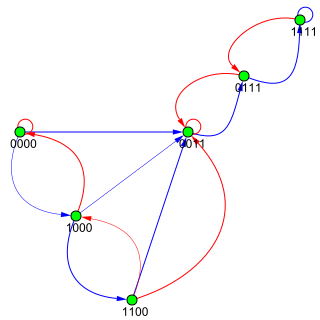

In [651]:
L = len(stable_states)
g = Graph(L, edges= total_edge_connection , directed =True)
x_lim = 300
y_lim = 300
x_lim_final = 320
y_lim_final = 320
coor = []
x_position = 10
y_position = 300
y_len= y_lim/(L+1)
x_len = x_lim/(L+1)
for j in range(L+1):
    x_position += x_len 
    y_position -= y_len +  np.random.choice((-1, 1))*3*y_len
    coor.append([x_position, y_position])
layout = [[0, 300], [300, 300 ], [100,450], [200, 600 ], [400, 200],  [500, 100]]
edge_curved = (0, 0.8, 0, 1, 1.15, 0.8, 0.8, 0, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8 )
ig.plot(g, layout = layout, 
        edge_width = width, edge_curved = edge_curved, edge_arrow_width = 0.8, edge_arrow_size= 0.7, 
        edge_color = color, vertex_color = "green", vertex_label= stable_states ,vertex_label_angle = 5, 
                  bbox=(0, 0, x_lim_final, y_lim_final ), vertex_size = 10, vertex_label_dist= 1.5,vertex_label_color = "black",
        vertex_label_size = 12)
# edge_curved = 